==== Anlage des Spark Context ====

**Spark-Session erstellen und notwendige Frameworks importieren**

In [1]:
import findspark
findspark.init()
import pyspark
 

conf = pyspark.SparkConf()
#conf.set("spark.driver.bindAddress", "127.0.0.1")  # Localhost
#conf = conf.setMaster("local[*]")
conf = conf.setAppName("App")

try:
    sc = pyspark.SparkContext(conf=conf)
except Exception as e:
    print(f"Fehler:  {e}")

Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
25/01/13 17:22:07 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


----------------------------------------
Exception occurred during processing of request from ('127.0.0.1', 52330)
Traceback (most recent call last):
  File "/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/socketserver.py", line 318, in _handle_request_noblock
    self.process_request(request, client_address)
  File "/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/socketserver.py", line 349, in process_request
    self.finish_request(request, client_address)
  File "/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/socketserver.py", line 362, in finish_request
    self.RequestHandlerClass(request, client_address, self)
  File "/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/socketserver.py", line 761, in __init__
    self.handle()
  File "/usr/local/spark-3.5.3-bin-hadoop3/python/pyspark/accumulators.py", line 295, in handle
    poll(accum_updates)
  File "/usr/local/spark-3.5.3-bin-hadoop3/python/pyspark/accumulator

In [14]:
# Falls Spark-Session mit Fehler startet -> stoppen
# sc.stop()

==== **Dateipfade festlegen und allgemeine Variable** ====

- `airport_data_path`: Pfad zur CSV-Datei mit Flughafendaten.
- `aircraft_data_path`: Pfad zur CSV-Datei mit vollständigen Flugzeugdaten (`aircraft-database-complete-2024-10.csv`).
- `flight_data_path`: Pfad zur CSV-Datei mit vorverarbeiteten Flugbewegungsdaten (`processed_data_reduced.csv`).

In [2]:
airport_data_path = "data/airports.csv"
aircraft_data_path = 'data/aircraft-database-complete-2024-10.csv'
flight_data_path = 'data/processed_data_reduced.csv'

dquote='\"'

==== **Vorverarbeitung der Datenquelle** ===
- Laden: Liest eine Pipe-getrennte CSV-Datei (`data.csv`).
- Spalten auswählen und umbenennen**: Wählt die Spalten `icao24`, `time`, `latitude`, `longitude`, `onground` aus und benennt sie um.
- Daten konvertieren**:
    - Zeit: Wandelt Unix-Timestamps in lesbares Format um.
    - Status: Konvertiert `onground` von `true`/`false` zu `1`/`0`.
- Speichern: Speichert die bereinigten Daten in `processed_data.csv`.

In [4]:
#import pandas as pd
#from datetime import datetime

# CSV-Datei laden, wobei das Pipe-Zeichen als Trennzeichen angegeben wird
#csv_file_path = "data.csv"  # Ersetze dies mit dem Pfad zu deiner CSV-Datei
#df = pd.read_csv(csv_file_path, sep='|')  # Verwende '|' als Trennzeichen

# Angenommene Spaltennummern: time = 0, icao24 = 1, lat = 2, lon = 3, onground = 4
#column_indices = [1, 0, 2, 3, 4]  # Die Spalten in der gewünschten Reihenfolge auswählen
#df_selected = df.iloc[:, column_indices]

# Umbenennen der Spalten
#df_selected.columns = ['time', 'icao24', 'latitude', 'longitude', 'onground']

# Funktion zur Konvertierung des Unix-Timestamps
#def convert_timestamp(unix_timestamp):
#    try:
#        return datetime.utcfromtimestamp(int(unix_timestamp)).strftime('%Y/%m/%d %H:%M:%S')
#    except ValueError:
#        return None

# Konvertiere die 'time'-Spalte
#df_selected['time'] = df_selected['time'].apply(convert_timestamp)

# Umwandlung der 'onground'-Spalte, 'true' -> 1 und 'false' -> 0
#df_selected['onground'] = df_selected['onground'].apply(lambda x: 1 if str(x).strip().lower() == 'true' else 0)

# Sicherstellen, dass 'time' an erster Stelle bleibt
#df_selected = df_selected[['time', 'icao24', 'latitude', 'longitude', 'onground']]

# Speichere das Ergebnis als neue CSV-Datei
#df_selected.to_csv("processed_data.csv", index=False)

**POC zu Parquet**

- Liest ein Parquet-File (`bigDataSet_v2.parquet`) in einen Spark DataFrame.  
- Zeigt die ersten 3 Zeilen (`df.show(3)`) und druckt Schema und Spaltennamen.  
- Wandelt den DataFrame in ein RDD um (`df.rdd`) und gibt die ersten 3 Einträge aus (`rdd.take(3)`).

In [5]:
#Code wie man das Parquet File anlegt

In [3]:
from pyspark.sql import SparkSession

spark = SparkSession.builder \
    .appName("Inspect Parquet") \
    .getOrCreate()

df = spark.read.parquet("data/bigDataSet_v2.parquet")
df.show(3)  # Zeigt die ersten 5 Zeilen der Parquet-Datei

df.printSchema()
print("Spaltennamen:", df.columns)

# Umwandeln des DataFrames in ein RDD
rdd = df.rdd

# Ausgabe der ersten 3 Zeilen
print(rdd.take(3))

+--------+--------------------+---------------------+----------+
| icao24 |        lat         |         lon         | onground |
+--------+--------------------+---------------------+----------+
|    NULL|                NULL|                 NULL|      NULL|
| a42f8b |   37.73231118412341|  -119.22649881114133| false    |
| a42f8b |   37.72737121582031|   -119.2253275120512| false    |
+--------+--------------------+---------------------+----------+
only showing top 3 rows

root
 |--  icao24 : string (nullable = true)
 |--         lat         : double (nullable = true)
 |--          lon         : double (nullable = true)
 |--  onground : string (nullable = true)

Spaltennamen: [' icao24 ', '        lat         ', '         lon         ', ' onground ']
[Row( icao24 =None,         lat         =None,          lon         =None,  onground =None), Row( icao24 =' a42f8b ',         lat         =37.73231118412341,          lon         =-119.22649881114133,  onground =' false    '), Row( icao2

==== **Durchführen der Datenanlyse** ====

**Auswertung 1 - Weltweite Flughäfen**

- Liest eine CSV-Datei mit weltweiten Flughafendaten ein und verarbeitet sie als RDD.  
- Filtert nach ausgewählten Spalten, entfernt den Header und parst die Daten korrekt als CSV.  
- Bestimmt die Anzahl aller relevanten Flughäfen/Heliports und zählt diese nach Typ.  
- Gibt einen formatierten Ergebnis-String und das RDD zurück.

Skalierbarkeit:
- Verarbeitungslaufzeit wächst proportional zur Datenmenge
- Datenfluss
    - IO-gebunden: Einlesen der Daten aus dem Dateisystem -> Einfach zu skalieren
    - CPU-gebunden: Parsen und Filtern der CSV-Daten -> Einfach zu skalieren
    - Memory-gebunden: Aggregationen und Zählungen im Speicher -> Schwer zu skalieren
- Fehlertoleranz:
    - RDDs ermöglichen automatische Wiederherstellung bei Ausfällen
    - Daten werden über mehrere Knoten repliziert
- Optimiert für Batch-Verarbeitung, nicht für Echtzeitanalysen
- Dimenisonierung eines realen Systems
    - Ausreichend Knoten mit ausreichendem CPU- und Speicher
    - Kontinuierliches Monitoring und Anpassungen basierend auf Leistungskennzahlen

In [4]:
import csv
from io import StringIO

def analyze_airports(airport_data_path):
    """
    Analysiert Flughäfen weltweit und gibt die Anzahl als String zurück.
    
    :return: Formatierten String mit den Ergebnissen und das zugehörige RDD.
    """

    # Daten einlesen und Header extrahieren
    airportRDD = sc.textFile(airport_data_path)
    header = airportRDD.first()

    # CSV korrekt parsen, um Fehler durch Kommata innerhalb von Anführungszeichen zu vermeiden
    def parse_csv(line):
        reader = csv.reader(StringIO(line))
        return next(reader)

    # Filterkriterien anwenden und nur die relevanten Spalten speichern (1, 2, 3, 4, 5, 7)
    airportRDD = (
        airportRDD.filter(lambda line: line != header)  # Header entfernen
                  .map(parse_csv)  # CSV korrekt parsen
                  .filter(lambda cols: len(cols) > 7)  # Sicherstellen, dass genug Spalten vorhanden sind
                  .map(lambda cols: (cols[1].strip('"'),  # Name
                                    cols[2].strip('"'),  # Typ
                                    cols[3].strip('"'),  # Breitengrad
                                    cols[4].strip('"'),  # Längengrad
                                    cols[5].strip('"'),  # Höhe
                                    #cols[7].strip('"')
                                    ))  # Kontinent
                  .filter(lambda cols: cols[1] in ["small_airport", "medium_airport", "large_airport", "heliport"])  # Nur bestimmte Typen
    )

    # Anzahl der Flughäfen insgesamt
    total_airports = airportRDD.count()

    # Anzahl der Flughäfen nach Kategorien
    categorized_airports = (
        airportRDD.map(lambda cols: cols[1])  # Typ (Spalte 2)
                  .countByValue()
    )

    # Formatierte Ausgabe als String erstellen
    result = "Analyse weltweiter Flughäfen und Heliports\n"
    result += "=" * 50 + "\n"

    result += f"Die Anzahl der weltweiten Flughäfen und Heliports beträgt: {total_airports}\n"
    result += f"Davon Heliports: {categorized_airports.get('heliport', 0)}\n"
    result += f"Davon kleine Flughäfen: {categorized_airports.get('small_airport', 0)}\n"
    result += f"Davon mittelgroße Flughäfen: {categorized_airports.get('medium_airport', 0)}\n"
    result += f"Davon große Flughäfen: {categorized_airports.get('large_airport', 0)}\n"

    return result, airportRDD

# Beispielaufruf und Ausgabe
result, airportRDD = analyze_airports(airport_data_path)
print(result)

# Optional: Die Daten aus airportRDD anzeigen lassen
#airportRDD.collect()


Analyse weltweiter Flughäfen und Heliports
Die Anzahl der weltweiten Flughäfen und Heliports beträgt: 67961
Davon Heliports: 21081
Davon kleine Flughäfen: 41706
Davon mittelgroße Flughäfen: 4700
Davon große Flughäfen: 474



In [7]:
airportRDD.collect()


[('00A', 'heliport', 'Total RF Heliport', '40.070985', '-74.933689'),
 ('00AA', 'small_airport', 'Aero B Ranch Airport', '38.704022', '-101.473911'),
 ('00AK', 'small_airport', 'Lowell Field', '59.947733', '-151.692524'),
 ('00AL',
  'small_airport',
  'Epps Airpark',
  '34.86479949951172',
  '-86.77030181884766'),
 ('00AN', 'small_airport', 'Katmai Lodge Airport', '59.093287', '-156.456699'),
 ('00AS', 'small_airport', 'Fulton Airport', '34.9428028', '-97.8180194'),
 ('00AZ',
  'small_airport',
  'Cordes Airport',
  '34.305599212646484',
  '-112.16500091552734'),
 ('00CA',
  'small_airport',
  'Goldstone (GTS) Airport',
  '35.35474',
  '-116.885329'),
 ('00CL', 'small_airport', 'Williams Ag Airport', '39.427188', '-121.763427'),
 ('00CN',
  'heliport',
  'Kitchen Creek Helibase Heliport',
  '32.7273736',
  '-116.4597417'),
 ('00FA',
  'small_airport',
  'Grass Patch Airport',
  '28.64550018310547',
  '-82.21900177001953'),
 ('00FL',
  'small_airport',
  'River Oak Airport',
  '27.2308

**Auswertung 2 - Registrierte Flugobjekte**

Liest eine CSV-Datei mit Flugzeugdaten und entfernt den Header.
- Zählt die Anzahl registrierter Flugobjekte.
- Ermittelt die Top 20 Airlines nach Anzahl der registrierten Flugzeuge.
- Gibt einen formatierten String und zwei RDDs zurück (gefilterte Daten und Airlines mit Anzahl).


Skalierbarkeit
- Verarbeitungslaufzeit wächst proportional zur Datenmenge
- Datenfluss
    - IO-gebunden: Einlesen der Daten aus dem Dateisystem → Einfach zu skalieren
    - CPU-gebunden: Parsen und Filtern der CSV-Daten → Einfach zu skalieren
    - Memory-gebunden: Aggregationen und Sortierungen im Speicher → Schwer zu skalieren
- Fehlertoleranz:
    - RDDs ermöglichen automatische Wiederherstellung bei Ausfällen
    - Daten werden über mehrere Knoten repliziert
- Optimiert für Batch-Verarbeitung, nicht für Echtzeitanalysen
- Dimensionierung eines realen Systems:
    - Ausreichend Knoten mit ausreichendem CPU- und Speicher
    - Kontinuierliches Monitoring und Anpassungen basierend auf Leistungskennzahlen

In [5]:
def analyze_aircraft_data(aircraft_data_path):
    
    """
    Analysiert eine CSV-Datei mit Flugzeugdaten, um die Gesamtanzahl der registrierten Flugobjekte 
    sowie die Top 20 Airlines nach der Anzahl der registrierten Flugzeuge zu ermitteln.

    Die Funktion liest die Daten aus einer festgelegten CSV-Datei, filtert ungültige Einträge 
    und verarbeitet die Informationen mithilfe von Spark. 

    :return: Ein Tupel bestehend aus:
        - result (str): Ein formatierter String mit der Gesamtanzahl der Flugobjekte 
                        und den Top 20 Airlines nach Anzahl registrierter Flugzeuge.
        - aircraft_raw_rdd (RDD): Ein Spark RDD mit den gefilterten Flugzeugdaten.
        - aircraftRDD (RDD): Ein Spark RDD, das die Airlines und die Anzahl ihrer Flugzeuge enthält.
    """

    # Daten einlesen und Header extrahieren
    aircraft_input_rdd = sc.textFile(aircraft_data_path)
    header = aircraft_input_rdd.first()

    # Filterkriterien anwenden: Entfernen des Headers
    aircraft_raw_rdd = aircraft_input_rdd.filter(lambda line: line != header)
    
    # Anzahl der registrierten Flugobjekte
    Anzahl_registrierte_Flugobjekte = aircraft_raw_rdd.count()

    # RDD erstellen, um die Airlines nach Anzahl der registrierten Flugzeuge zu zählen
    aircraftRDD = (
        aircraft_raw_rdd.filter(lambda line: len(line.split(",")) > 16)
        .map(lambda line: line.split(",")[17].strip('"'))
        .filter(lambda airline: airline != "''")
        .map(lambda airline: (airline, 1))
        .reduceByKey(lambda a, b: a + b)
        .sortBy(lambda x: x[1], ascending=False)
    )
    
    # Top 20 Airlines nach Anzahl der registrierten Flugzeuge
    top_20_airlines = aircraftRDD.take(20)

    # Ergebnis als formatierten String zurückgeben
    result = f"Anzahl der weltweit gemeldeten, eindeutigen Flug- und Bodenobjekte: {Anzahl_registrierte_Flugobjekte}\n"
    result += "=" * 50 + "\n"
    result += "Top 20 Airlines nach Anzahl der registrierten Flugzeuge:\n"
    result += "=" * 50 + "\n"

    for airline, count in top_20_airlines:
        result += f"{airline}: {count}\n"

    return result, aircraft_raw_rdd, aircraftRDD

# Beispielaufruf und Ausgabe
result, aircraft_raw_rdd, aircraftRDD = analyze_aircraft_data(aircraft_data_path)
print(result)


Anzahl der weltweit gemeldeten, eindeutigen Flug- und Bodenobjekte: 601337
Top 20 Airlines nach Anzahl der registrierten Flugzeuge:
United States Air Force: 2223
Delta Air Lines: 781
American Airlines: 657
Corporate Airlink: 649
Federal Express: 560
Royal Air Force: 503
United Airlines: 451
Southwest Airlines: 280
German Air Force: 277
Boeing: 274
United Parcel Service: 270
Indian Air Force: 236
Force Aerienne Francaise: 223
Gulfstream Aerospace: 201
Bombardier: 190
Ryanair: 159
Qatar Airways: 157
Skywest Airlines: 153
Aeroflot Russian Airlines: 147
Royal Netherlands Air Force: 144



**Auswertung 3 - Weltweite Bewegungsdaten von Flugobjekten in einer Woche**

- Liest Flugbewegungsdaten ein, entfernt Header und ungültige Einträge.
- Nutzt einen einstellbaren Prozentsatz der Daten (`sampleRDD`).
- Bestimmt den zeitlichen Rahmen (erstes und letztes Datum) sowie min./max. Längen- und Breitengrad.
- Berechnet das Zentrum und erzeugt eine Folium-Karte mit einem Rechteck des betrachteten Luftraums.
- Gibt einen Ergebnis-Text, die Karte und das gefilterte RDD zurück.

Skalierbarkeit
- Verarbeitungslaufzeit wächst proportional zur Datenmenge
- Datenfluss
    - IO-gebunden: Einlesen der Daten aus dem Dateisystem → Einfach zu skalieren
    - CPU-gebunden: Parsen und Filtern der CSV-Daten → Gut zu skalieren
    - Memory-gebunden: Aggregationen und Sortierungen im Speicher → Schwer zu skalieren
    - Visualisierung mit Folium: Erstellen und Rendern der Karte erfolgt auf dem Driver, bei großen geografischen Bereichen viel Speicher und CPU
- Fehlertoleranz:
    - RDDs ermöglichen automatische Wiederherstellung bei Ausfällen
    - Daten werden über mehrere Knoten repliziert
    - Teilweise Ausfälle beeinflussen nicht den Prozess
- Optimiert für Batch-Verarbeitung, nicht für Echtzeitanalysen
- Dimensionierung eines realen Systems:
    - Ausreichend Knoten mit ausreichendem CPU- und Speicher
    - Kontinuierliches Monitoring und Anpassungen basierend auf Leistungskennzahlen
    - Optimierung der Visualisierung bspw. durch separate Ressourcen für die Generierung der Folium-Karte

In [6]:
import folium

# Analyse der Bewegungsdaten
def analyze_flight_movements(flight_data_path, percentage=1.0):
    """
    Analysiert Bewegungsdaten von Flugzeugen und erstellt eine Karte des geografischen Bereichs.
    Misst dabei die Laufzeit für die Verarbeitung des Prozentsatzes der Daten.
    
    :param percentage: Prozentsatz (zwischen 0 und 1) der Daten, die geladen werden sollen (Standard: 100%)
    :return: Die Ergebnisse der Auswertung, generierte Karte und das RDD der Daten sowie die benötigte Zeit
    """

    if not 0 < percentage <= 1:
        raise ValueError("Percentage muss zwischen 0 und 1 liegen")
    
    # Einlesen der Bewegungsdaten eines definierten Zeitraums in einem bestimmten geografischen Bereich
    myFileRDD = sc.textFile(flight_data_path)
    header = myFileRDD.take(1)
    sampleRDD_with_null = myFileRDD.filter(lambda line: line not in header)
    sampleRDD = sampleRDD_with_null.filter(lambda line: "NULL" not in line)

    #Reduktion des RDDs auf Prozentwert an Datensätzen, seed sorgt für reproduzierbare Zufallsergebnisse (42 ist die Antwort auf alles).
    dataRDD = sampleRDD.sample(False, percentage, seed=42)

    #Erfassen des Zeitraums in dem Daten die erhoben wurden - Skalierbarkeit gegeben aufgrund der Rückgabe eines Wertes
    start_time = dataRDD.map(lambda line: line.split(',')[0]).min()
    end_time = dataRDD.map(lambda line: line.split(',')[0]).max()

    #Geographische Analyse des betrachteten Luftraums - Skalierbarkeit gegeben aufgrund der Rückgabe und Visualisierung einzelner Werte

    # Längengrade sortieren und auslesen
    min_longitude = dataRDD.map(lambda line: float(line.split(',')[3])).min()
    max_longitude = dataRDD.map(lambda line: float(line.split(',')[3])).max()

    # Breitengrade (vermutlich Spalte mit Index 5 und 6)
    min_latitude = dataRDD.map(lambda line: float(line.split(',')[2])).min()
    max_latitude = dataRDD.map(lambda line: float(line.split(',')[2])).max()

    # Zentrum des Bereichs berechnen
    center_lat = (min_latitude + max_latitude) / 2
    center_lon = (min_longitude + max_longitude) / 2
    result_text = (
        f"Die erfassten Bewegungen von Flug- und Bodenobjekten wurden im Zeitraum vom "
        f"{start_time.replace(dquote, '').replace('+00', '')} bis zum "
        f"{end_time.replace(dquote, '').replace('+00', '')} (Zeitzone: UTC) ermittelt.\n"
        f"{'=' * 50}\n"
        "Geografische Abdeckung:\n"
        f"Längengrade: von {min_longitude:.4f}° bis {max_longitude:.4f}°\n"
        f"Breitengrade: von {min_latitude:.4f}° bis {max_latitude:.4f}°\n"
        "Die Daten wurden in folgendem Luftraum erhoben."
    )

    # Karte erstellen
    map = folium.Map(location=[center_lat, center_lon], zoom_start=5)

    # Rechteck auf der Karte hinzufügen
    bounds = [[min_latitude, min_longitude], [max_latitude, max_longitude]]
    folium.Rectangle(
        bounds=bounds,
        color="red",
        weight=2,
        fill=True,
        fill_color="blue",
        fill_opacity=0.2,
        popup="Geographischer Bereich"
    ).add_to(map)

    return result_text, map, dataRDD,  

result_text, map_result, dataRDD = analyze_flight_movements(flight_data_path)
print(result_text)
map_result

25/01/13 17:22:37 ERROR Executor: Exception in task 0.0 in stage 18.0 (TID 153) 
org.apache.spark.api.python.PythonException: Traceback (most recent call last):
  File "/usr/local/spark-3.5.3-bin-hadoop3/python/lib/pyspark.zip/pyspark/worker.py", line 1247, in main
    process()
  File "/usr/local/spark-3.5.3-bin-hadoop3/python/lib/pyspark.zip/pyspark/worker.py", line 1239, in process
    serializer.dump_stream(out_iter, outfile)
  File "/usr/local/spark-3.5.3-bin-hadoop3/python/lib/pyspark.zip/pyspark/serializers.py", line 274, in dump_stream
    vs = list(itertools.islice(iterator, batch))
         ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/spark-3.5.3-bin-hadoop3/python/pyspark/rdd.py", line 1919, in func
    initial = next(iterator)
              ^^^^^^^^^^^^^^
  File "/usr/local/spark-3.5.3-bin-hadoop3/python/lib/pyspark.zip/pyspark/util.py", line 83, in wrapper
    return f(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^
  File "/var/folders/px/ds2qjctx44s3th40sp8b

Py4JJavaError: An error occurred while calling z:org.apache.spark.api.python.PythonRDD.collectAndServe.
: org.apache.spark.SparkException: Job aborted due to stage failure: Task 0 in stage 18.0 failed 1 times, most recent failure: Lost task 0.0 in stage 18.0 (TID 153) (mac.fritz.box executor driver): org.apache.spark.api.python.PythonException: Traceback (most recent call last):
  File "/usr/local/spark-3.5.3-bin-hadoop3/python/lib/pyspark.zip/pyspark/worker.py", line 1247, in main
    process()
  File "/usr/local/spark-3.5.3-bin-hadoop3/python/lib/pyspark.zip/pyspark/worker.py", line 1239, in process
    serializer.dump_stream(out_iter, outfile)
  File "/usr/local/spark-3.5.3-bin-hadoop3/python/lib/pyspark.zip/pyspark/serializers.py", line 274, in dump_stream
    vs = list(itertools.islice(iterator, batch))
         ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/spark-3.5.3-bin-hadoop3/python/pyspark/rdd.py", line 1919, in func
    initial = next(iterator)
              ^^^^^^^^^^^^^^
  File "/usr/local/spark-3.5.3-bin-hadoop3/python/lib/pyspark.zip/pyspark/util.py", line 83, in wrapper
    return f(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^
  File "/var/folders/px/ds2qjctx44s3th40sp8b67y80000gn/T/ipykernel_16713/3947248697.py", line 32, in <lambda>
ValueError: could not convert string to float: ''

	at org.apache.spark.api.python.BasePythonRunner$ReaderIterator.handlePythonException(PythonRunner.scala:572)
	at org.apache.spark.api.python.PythonRunner$$anon$3.read(PythonRunner.scala:784)
	at org.apache.spark.api.python.PythonRunner$$anon$3.read(PythonRunner.scala:766)
	at org.apache.spark.api.python.BasePythonRunner$ReaderIterator.hasNext(PythonRunner.scala:525)
	at org.apache.spark.InterruptibleIterator.hasNext(InterruptibleIterator.scala:37)
	at scala.collection.Iterator.foreach(Iterator.scala:943)
	at scala.collection.Iterator.foreach$(Iterator.scala:943)
	at org.apache.spark.InterruptibleIterator.foreach(InterruptibleIterator.scala:28)
	at scala.collection.generic.Growable.$plus$plus$eq(Growable.scala:62)
	at scala.collection.generic.Growable.$plus$plus$eq$(Growable.scala:53)
	at scala.collection.mutable.ArrayBuffer.$plus$plus$eq(ArrayBuffer.scala:105)
	at scala.collection.mutable.ArrayBuffer.$plus$plus$eq(ArrayBuffer.scala:49)
	at scala.collection.TraversableOnce.to(TraversableOnce.scala:366)
	at scala.collection.TraversableOnce.to$(TraversableOnce.scala:364)
	at org.apache.spark.InterruptibleIterator.to(InterruptibleIterator.scala:28)
	at scala.collection.TraversableOnce.toBuffer(TraversableOnce.scala:358)
	at scala.collection.TraversableOnce.toBuffer$(TraversableOnce.scala:358)
	at org.apache.spark.InterruptibleIterator.toBuffer(InterruptibleIterator.scala:28)
	at scala.collection.TraversableOnce.toArray(TraversableOnce.scala:345)
	at scala.collection.TraversableOnce.toArray$(TraversableOnce.scala:339)
	at org.apache.spark.InterruptibleIterator.toArray(InterruptibleIterator.scala:28)
	at org.apache.spark.rdd.RDD.$anonfun$collect$2(RDD.scala:1049)
	at org.apache.spark.SparkContext.$anonfun$runJob$5(SparkContext.scala:2433)
	at org.apache.spark.scheduler.ResultTask.runTask(ResultTask.scala:93)
	at org.apache.spark.TaskContext.runTaskWithListeners(TaskContext.scala:166)
	at org.apache.spark.scheduler.Task.run(Task.scala:141)
	at org.apache.spark.executor.Executor$TaskRunner.$anonfun$run$4(Executor.scala:620)
	at org.apache.spark.util.SparkErrorUtils.tryWithSafeFinally(SparkErrorUtils.scala:64)
	at org.apache.spark.util.SparkErrorUtils.tryWithSafeFinally$(SparkErrorUtils.scala:61)
	at org.apache.spark.util.Utils$.tryWithSafeFinally(Utils.scala:94)
	at org.apache.spark.executor.Executor$TaskRunner.run(Executor.scala:623)
	at java.util.concurrent.ThreadPoolExecutor.runWorker(ThreadPoolExecutor.java:1149)
	at java.util.concurrent.ThreadPoolExecutor$Worker.run(ThreadPoolExecutor.java:624)
	at java.lang.Thread.run(Thread.java:750)

Driver stacktrace:
	at org.apache.spark.scheduler.DAGScheduler.failJobAndIndependentStages(DAGScheduler.scala:2856)
	at org.apache.spark.scheduler.DAGScheduler.$anonfun$abortStage$2(DAGScheduler.scala:2792)
	at org.apache.spark.scheduler.DAGScheduler.$anonfun$abortStage$2$adapted(DAGScheduler.scala:2791)
	at scala.collection.mutable.ResizableArray.foreach(ResizableArray.scala:62)
	at scala.collection.mutable.ResizableArray.foreach$(ResizableArray.scala:55)
	at scala.collection.mutable.ArrayBuffer.foreach(ArrayBuffer.scala:49)
	at org.apache.spark.scheduler.DAGScheduler.abortStage(DAGScheduler.scala:2791)
	at org.apache.spark.scheduler.DAGScheduler.$anonfun$handleTaskSetFailed$1(DAGScheduler.scala:1247)
	at org.apache.spark.scheduler.DAGScheduler.$anonfun$handleTaskSetFailed$1$adapted(DAGScheduler.scala:1247)
	at scala.Option.foreach(Option.scala:407)
	at org.apache.spark.scheduler.DAGScheduler.handleTaskSetFailed(DAGScheduler.scala:1247)
	at org.apache.spark.scheduler.DAGSchedulerEventProcessLoop.doOnReceive(DAGScheduler.scala:3060)
	at org.apache.spark.scheduler.DAGSchedulerEventProcessLoop.onReceive(DAGScheduler.scala:2994)
	at org.apache.spark.scheduler.DAGSchedulerEventProcessLoop.onReceive(DAGScheduler.scala:2983)
	at org.apache.spark.util.EventLoop$$anon$1.run(EventLoop.scala:49)
	at org.apache.spark.scheduler.DAGScheduler.runJob(DAGScheduler.scala:989)
	at org.apache.spark.SparkContext.runJob(SparkContext.scala:2393)
	at org.apache.spark.SparkContext.runJob(SparkContext.scala:2414)
	at org.apache.spark.SparkContext.runJob(SparkContext.scala:2433)
	at org.apache.spark.SparkContext.runJob(SparkContext.scala:2458)
	at org.apache.spark.rdd.RDD.$anonfun$collect$1(RDD.scala:1049)
	at org.apache.spark.rdd.RDDOperationScope$.withScope(RDDOperationScope.scala:151)
	at org.apache.spark.rdd.RDDOperationScope$.withScope(RDDOperationScope.scala:112)
	at org.apache.spark.rdd.RDD.withScope(RDD.scala:410)
	at org.apache.spark.rdd.RDD.collect(RDD.scala:1048)
	at org.apache.spark.api.python.PythonRDD$.collectAndServe(PythonRDD.scala:195)
	at org.apache.spark.api.python.PythonRDD.collectAndServe(PythonRDD.scala)
	at sun.reflect.NativeMethodAccessorImpl.invoke0(Native Method)
	at sun.reflect.NativeMethodAccessorImpl.invoke(NativeMethodAccessorImpl.java:62)
	at sun.reflect.DelegatingMethodAccessorImpl.invoke(DelegatingMethodAccessorImpl.java:43)
	at java.lang.reflect.Method.invoke(Method.java:498)
	at py4j.reflection.MethodInvoker.invoke(MethodInvoker.java:244)
	at py4j.reflection.ReflectionEngine.invoke(ReflectionEngine.java:374)
	at py4j.Gateway.invoke(Gateway.java:282)
	at py4j.commands.AbstractCommand.invokeMethod(AbstractCommand.java:132)
	at py4j.commands.CallCommand.execute(CallCommand.java:79)
	at py4j.ClientServerConnection.waitForCommands(ClientServerConnection.java:182)
	at py4j.ClientServerConnection.run(ClientServerConnection.java:106)
	at java.lang.Thread.run(Thread.java:750)
Caused by: org.apache.spark.api.python.PythonException: Traceback (most recent call last):
  File "/usr/local/spark-3.5.3-bin-hadoop3/python/lib/pyspark.zip/pyspark/worker.py", line 1247, in main
    process()
  File "/usr/local/spark-3.5.3-bin-hadoop3/python/lib/pyspark.zip/pyspark/worker.py", line 1239, in process
    serializer.dump_stream(out_iter, outfile)
  File "/usr/local/spark-3.5.3-bin-hadoop3/python/lib/pyspark.zip/pyspark/serializers.py", line 274, in dump_stream
    vs = list(itertools.islice(iterator, batch))
         ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/spark-3.5.3-bin-hadoop3/python/pyspark/rdd.py", line 1919, in func
    initial = next(iterator)
              ^^^^^^^^^^^^^^
  File "/usr/local/spark-3.5.3-bin-hadoop3/python/lib/pyspark.zip/pyspark/util.py", line 83, in wrapper
    return f(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^
  File "/var/folders/px/ds2qjctx44s3th40sp8b67y80000gn/T/ipykernel_16713/3947248697.py", line 32, in <lambda>
ValueError: could not convert string to float: ''

	at org.apache.spark.api.python.BasePythonRunner$ReaderIterator.handlePythonException(PythonRunner.scala:572)
	at org.apache.spark.api.python.PythonRunner$$anon$3.read(PythonRunner.scala:784)
	at org.apache.spark.api.python.PythonRunner$$anon$3.read(PythonRunner.scala:766)
	at org.apache.spark.api.python.BasePythonRunner$ReaderIterator.hasNext(PythonRunner.scala:525)
	at org.apache.spark.InterruptibleIterator.hasNext(InterruptibleIterator.scala:37)
	at scala.collection.Iterator.foreach(Iterator.scala:943)
	at scala.collection.Iterator.foreach$(Iterator.scala:943)
	at org.apache.spark.InterruptibleIterator.foreach(InterruptibleIterator.scala:28)
	at scala.collection.generic.Growable.$plus$plus$eq(Growable.scala:62)
	at scala.collection.generic.Growable.$plus$plus$eq$(Growable.scala:53)
	at scala.collection.mutable.ArrayBuffer.$plus$plus$eq(ArrayBuffer.scala:105)
	at scala.collection.mutable.ArrayBuffer.$plus$plus$eq(ArrayBuffer.scala:49)
	at scala.collection.TraversableOnce.to(TraversableOnce.scala:366)
	at scala.collection.TraversableOnce.to$(TraversableOnce.scala:364)
	at org.apache.spark.InterruptibleIterator.to(InterruptibleIterator.scala:28)
	at scala.collection.TraversableOnce.toBuffer(TraversableOnce.scala:358)
	at scala.collection.TraversableOnce.toBuffer$(TraversableOnce.scala:358)
	at org.apache.spark.InterruptibleIterator.toBuffer(InterruptibleIterator.scala:28)
	at scala.collection.TraversableOnce.toArray(TraversableOnce.scala:345)
	at scala.collection.TraversableOnce.toArray$(TraversableOnce.scala:339)
	at org.apache.spark.InterruptibleIterator.toArray(InterruptibleIterator.scala:28)
	at org.apache.spark.rdd.RDD.$anonfun$collect$2(RDD.scala:1049)
	at org.apache.spark.SparkContext.$anonfun$runJob$5(SparkContext.scala:2433)
	at org.apache.spark.scheduler.ResultTask.runTask(ResultTask.scala:93)
	at org.apache.spark.TaskContext.runTaskWithListeners(TaskContext.scala:166)
	at org.apache.spark.scheduler.Task.run(Task.scala:141)
	at org.apache.spark.executor.Executor$TaskRunner.$anonfun$run$4(Executor.scala:620)
	at org.apache.spark.util.SparkErrorUtils.tryWithSafeFinally(SparkErrorUtils.scala:64)
	at org.apache.spark.util.SparkErrorUtils.tryWithSafeFinally$(SparkErrorUtils.scala:61)
	at org.apache.spark.util.Utils$.tryWithSafeFinally(Utils.scala:94)
	at org.apache.spark.executor.Executor$TaskRunner.run(Executor.scala:623)
	at java.util.concurrent.ThreadPoolExecutor.runWorker(ThreadPoolExecutor.java:1149)
	at java.util.concurrent.ThreadPoolExecutor$Worker.run(ThreadPoolExecutor.java:624)
	... 1 more


**Auswertung 4 - Kombination Flugobjekte und Bewegungsdaten**

- Liest Bewegungsdaten (Zeitstempel, Koordinaten, Flugzeug-ID etc.) ein.  
- Parsed jeden Datensatz zu einem Key-Value-Paar (`icao24` als Schlüssel und weitere Daten als Dictionary).  
- Gruppiert danach alle Einträge mit derselben Flugzeug-ID und gibt ein RDD zurück, in dem jeder Schlüssel einer Liste seiner Bewegungsdaten zugeordnet ist.


Skalierbarkeit
- Verarbeitungslaufzeit wächst proportional zur Datenmenge
- Datenfluss
    - IO-gebunden: Einlesen der Daten aus dem Dateisystem → Einfach zu skalieren
    - CPU-gebunden: Parsen und Filtern der CSV-Daten → Gut zu skalieren
    - Memory-gebunden: Aggregationen und Sortierungen im Speicher → Schwer zu skalieren
- Fehlertoleranz:
    - RDDs ermöglichen automatische Wiederherstellung bei Ausfällen
    - Daten werden über mehrere Knoten repliziert
    - Teilweise Ausfälle beeinflussen nicht den Prozess
- Optimiert für Batch-Verarbeitung, nicht für Echtzeitanalysen
- Dimensionierung eines realen Systems:
    - Ausreichend Knoten mit ausreichendem CPU- und Speicher
    - Kontinuierliches Monitoring und Anpassungen basierend auf Leistungskennzahlen
    - Optimierung des Speichers: genügend Speicher für Join-Operationen und Aggregationen

Kombination der Bewegungsdaten

- Parst das `aircraft_raw_rdd`, um zu jedem Flugzeug die zugehörigen Informationen (Hersteller, Modell, Airline usw.) zu extrahieren.  
- Verknüpft diese Informationen mithilfe einer `leftOuterJoin` mit den bereits gruppierten Bewegungsdaten (`vehicle_rdd`).  
- Gibt ein kombiniertes RDD zurück, in dem für jede Flugzeug-ID sowohl die sortierten Bewegungsdaten als auch die Flugzeuginformationen hinterlegt sind.

In [8]:
# Kombination der Bewegungsdaten mit den Daten der registrierten Flug- und Bodenobjekten

def combine_rdds(vehicle_rdd, aircraft_raw_rdd):
    """
    Kombiniert die Bewegungsdaten gruppiert nach Fahrzeug über icao (vehicle_rdd) mit den Daten der registrierten Flug- und Bodenobjekte (aircraft_raw_rdd).

    Args:
        vehicle_rdd: Ein RDD mit Bewegungsdaten.
        aircraft_raw_rdd: Ein RDD mit Rohdaten zu registrierten Flug- und Bodenobjekten.

    Returns:
        Ein kombiniertes RDD mit Flugzeug-ID, Flugdaten und Beschreibungen.
    """
    def parse_type(line):
        parts = line.split(',')
        # Baseline-Verarbeitung ohne unnötige Komplexität
        return (
            parts[0].strip("'"),  # Flugzeug-ID (icao24)
            {
                "description": parts[5].strip("'") if len(parts) > 4 else "",
                "manufacturer": parts[13].strip("'") if len(parts) > 12 else "",
                "model": parts[14].strip("'") if len(parts) > 14 else "",
                "type": parts[15].strip("'") if len(parts) > 15 else "",
                "airline": parts[18].strip("'") if len(parts) > 16 else ""
            }
        )

    # RDD bereinigen und nur relevante Daten aufnehmen
    cleaned_type_rdd = aircraft_raw_rdd.map(parse_type)

    # Kombination der Bewegungsdaten mit der Beschreibung der registrierten Flug- und Bodenobjekten
    result_rdd = vehicle_rdd.leftOuterJoin(cleaned_type_rdd)

    # Kombination der Daten in einem RDD
    combined_rdd = result_rdd.map(lambda x: (
        x[0],  # Flugzeug-ID
        {
            "aircraft_info": x[1][1] if x[1][1] else {},  # Beschreibung, falls vorhanden
            "flight_data": sorted(x[1][0], key=lambda entry: entry["time"]) if x[1][0] else [] # Flugdaten sortiert nach Datum (lexografisch)
        }
    ))

    return combined_rdd


combined_rdd = combine_rdds(vehicle_rdd, aircraft_raw_rdd)
#combined_rdd.take(1)

NameError: name 'vehicle_rdd' is not defined

25/01/13 18:45:01 WARN HeartbeatReceiver: Removing executor driver with no recent heartbeats: 511266 ms exceeds timeout 120000 ms
25/01/13 18:45:01 WARN SparkContext: Killing executors is not supported by current scheduler.
25/01/13 18:45:04 WARN Executor: Issue communicating with driver in heartbeater
org.apache.spark.SparkException: Exception thrown in awaitResult: 
	at org.apache.spark.util.SparkThreadUtils$.awaitResult(SparkThreadUtils.scala:56)
	at org.apache.spark.util.ThreadUtils$.awaitResult(ThreadUtils.scala:310)
	at org.apache.spark.rpc.RpcTimeout.awaitResult(RpcTimeout.scala:75)
	at org.apache.spark.rpc.RpcEndpointRef.askSync(RpcEndpointRef.scala:101)
	at org.apache.spark.rpc.RpcEndpointRef.askSync(RpcEndpointRef.scala:85)
	at org.apache.spark.storage.BlockManagerMaster.registerBlockManager(BlockManagerMaster.scala:80)
	at org.apache.spark.storage.BlockManager.reregister(BlockManager.scala:642)
	at org.apache.spark.executor.Executor.reportHeartBeat(Executor.scala:1223)
	at o

Analyse des zuvor kombinierten RDD

- Nimmt ein kombiniertes RDD (Flugzeug- und Bewegungsdaten) und wendet eine Stichprobenziehung an (standardmäßig 100%).  
- Bestimmt die Gesamtzahl aktiver Flug- und Bodenobjekte, listet die Top 5 mit den meisten Datensätzen und zeigt an, wie viele gerade fliegen bzw. am Boden sind.  
- Analysiert außerdem, ob Objekte im gesamten Zeitraum nur am Boden, nur in der Luft oder teils geflogen sind.

In [ ]:
#Analyse des kombinierten RDDs (Bewegungsdaten + Beschreibung)

def analyze_combined_rdd(sampleRDD, percentage=1.0):
    """
    Analysiert ein kombiniertes RDD, das Bewegungsdaten von Flug- und Bodenobjekten enthält,
    und liefert eine detaillierte statistische Zusammenfassung der betrachteten Daten.

    Args:
    sampleRDD (RDD): Ein RDD, das Flug- und Bewegungsdaten von Objekten enthält, wobei jedes Element ein Tupel ist,
                      wobei das erste Element die Objekt-ID ist und das zweite Element ein Dictionary mit den Bewegungsdaten.
    percentage (float): Der Anteil der Stichprobe (zwischen 0 und 1) der RDD-Daten, die für die Analyse verwendet werden sollen. 
                        Standardwert ist 1.0 (100%).

    Returns:
    str: Eine formatierte Zeichenkette, die die Ergebnisse der Analyse zusammenfasst, einschließlich der Gesamtzahl der
         Objekte, der Flugzeuge mit den meisten Datensätzen und der Status- und Bewegungsanalyse für den betrachteten Zeitraum.

    """
    
    #Reduktion des RDDs auf Prozentwert an Datensätzen, seed sorgt für reproduzierbare Zufallsergebnisse (42 ist die Antwort auf alles).
    combined_rdd = sampleRDD.sample(False, percentage, seed=42)
    amount_of_aircrafts = combined_rdd.count()
    result = "=" * 50 + "\n"
    result += f"Anzahl der im betrachteten Zeitraum aktiven Flug- und Bodenobjekte: {amount_of_aircrafts}\n"
    
    #Ermittlung der Anzahl an Flug-Datensätze pro Flugzeug
    countdatasetsRDD = combined_rdd.map(lambda x: (x[0],len(x[1]['flight_data']))).sortBy(lambda x: x[1], ascending=False)
    first_5_elements = countdatasetsRDD.take(5)
    result += "=" * 50 + "\n"
    result += f"Flugzeuge mit den meisten Datensätzen (Top 5) sind: {first_5_elements}\n "
    result += "=" * 50 + "\n"


    # Bestimmung der Positon - Skalierbarkeit gegeben über Betrachtung einzelner Werte
    airRDD = combined_rdd.map(lambda x: (x[0], x[1]['flight_data'][-1]["onground"]))
    onground = airRDD.filter(lambda x: x[1]==1).count()
    inair = airRDD.filter(lambda x: x[1]==0).count()
    result += f"Status der Objekt zum letzten gemessenen Zeitpunkt: \n"
    result += f"Objekte aktuell in der Luft: {inair}\n"
    result += f"Objekte aktuell am Boden: {onground}\n"


    # Ermittlung der Position im Zeitraum - Skalierbarkeit gegeben über Betrachtung einzelner Werte
    nextRDD = combined_rdd.map(lambda x: (x[0], sum(datapoint["onground"] for datapoint in x[1]['flight_data']), len(x[1]['flight_data'])))
    calculatedRDD = nextRDD.map(lambda x: (x[0], x[1]/x[2]))
    startet_or_landed = calculatedRDD.filter(lambda x: x[1] < 1 and x[1] >0).count()
    not_started = calculatedRDD.filter(lambda x: x[1] == 1).count()
    nlRDD = calculatedRDD.filter(lambda x: x[1] == 0)
    not_landed = calculatedRDD.filter(lambda x: x[1] == 0).count()

    result += "=" * 50 + "\n"
    result += f"Im gesamten betrachteten Zeitraum sind: \n"
    result += f"Objekte nur am Boden geblieben: {not_started}\n"
    result += f"Objekte nur in der Luft geblieben: {not_landed}\n"
    result += f"Objekte gestartet oder gelandet: {startet_or_landed}"

 
    return combined_rdd, result

combined_analyzed_rdd, result = analyze_combined_rdd(combined_rdd)
print(result)

Anzahl der im betrachteten Zeitraum aktiven Flug- und Bodenobjekte: 464
Flugzeuge mit den meisten Datensätzen (Top 5) sind: [('4bc841', 3599), ('a08663', 3599), ('a3b268', 3599), ('4bb20b', 3599), ('a9b9e3', 3599)]
Status der Objekt zum letzten gemessenen Zeitpunkt: 
Objekte aktuell in der Luft: 382
Objekte aktuell am Boden: 82
Im gesamten betrachteten Zeitraum sind: 
Objekte nur am Boden geblieben: 37
Objekte nur in der Luft geblieben: 308
Objekte gestartet oder gelandet: 119


==== **Visuelle Analysen** ====

**Identifizierung von Starts und Landungen von Flugobjekten und Verknüpfung mit nahe gelegenen Flughäfen (innerhalb von 10 km)**

- Berechnet mithilfe der Haversine-Formel die Distanz zwischen zwei Koordinatenpunkten.  
- Erkennt Start- und Landemomente anhand von `onground`-Werten (`1 -> 0` und zurück).  
- Sucht zu jedem Start- und Landezeitpunkt den nächsten Flughafen (max. 10 km entfernt).  
- Ignoriert Datensätze von Oberflächenfahrzeugen (Surface Vehicles).  
- Gibt eine Liste mit allen erkannten Flügen inklusive Start-/Endkoordinaten und nächstgelegenen Flughäfen zurück.

Skalierbarkeit
- Verarbeitungslaufzeit wächst proportional zur Datenmenge
- Datenfluss
    - IO-gebunden: Einlesen der Daten aus dem Dateisystem → Einfach zu skalieren
    - CPU-gebunden: Parsen und Filtern der CSV-Daten → Gut zu skalieren
    - Memory-gebunden: Aggregationen und Sortierungen im Speicher → Schwer zu skalieren
- Fehlertoleranz:
    - RDDs ermöglichen automatische Wiederherstellung bei Ausfällen
    - Daten werden über mehrere Knoten repliziert
    - Teilweise Ausfälle beeinflussen nicht den Prozess
- Optimiert für Batch-Verarbeitung, nicht für Echtzeitanalysen
- Dimensionierung eines realen Systems:
    - Ausreichend Knoten mit ausreichendem CPU- und Speicher
    - Kontinuierliches Monitoring und Anpassungen basierend auf Leistungskennzahlen
    - Optimierung des Speichers: genügend Speicher für Join-Operationen und Aggregationen
    - Optimierung der Visualisierung: separate Ressourcen für die Generierung der Folium-Karte

In [17]:
import math

# Haversine-Funktion zum Berechnen der Distanz zwischen zwei Punkten
def haversine(lat1, lon1, lat2, lon2):
    R = 6371  # Erd-Radius in Kilometern
    d_lat = math.radians(lat2 - lat1)
    d_lon = math.radians(lon2 - lon1)
    a = math.sin(d_lat / 2.0) ** 2 + math.cos(math.radians(lat1)) * math.cos(math.radians(lat2)) * math.sin(d_lon / 2.0) ** 2
    c = 2 * math.atan2(math.sqrt(a), math.sqrt(1 - a))
    return R * c

def find_nearest_airport(lat, lon, airports):
    """
    Findet den nächsten Flughafen zu gegebenen Koordinaten innerhalb von 10 km.
    Gibt den Flughafen mit der geringsten Distanz zurück.
    """
    nearest_airport = None
    min_distance = float("inf")

    for airport in airports:
        airport_id, _, airport_name, airport_lat, airport_lon = airport
        airport_lat = float(airport_lat)
        airport_lon = float(airport_lon)
        distance = haversine(lat, lon, airport_lat, airport_lon)
        if distance <= 10 and distance < min_distance:  # Innerhalb von 10 km und geringste Distanz
            min_distance = distance
            nearest_airport = (airport_id, airport_name)

    if nearest_airport:
        return nearest_airport
    return None, None

def extract_flights_with_airports(record, airports):
    """
    Extrahiert Flüge und fügt Flughafendaten hinzu.
    """
    icao24, combined_rdd = record
    aircraft_info = combined_rdd['aircraft_info']
    flight_data = combined_rdd['flight_data']

    # Filter: Ignoriere Datensätze mit "Surface Vehicle" in der Beschreibung
    if 'description' in aircraft_info and 'Surface Vehicle' in aircraft_info['description']:
        return []

    flights = []
    current_flight = []
    in_flight = False
    previous_entry = None  # Variable, um den vorherigen Datensatz zu speichern

    for entry in flight_data:
        # Überprüfung, ob es sich um einen Start handelt
        if not in_flight and entry['onground'] == 0 and previous_entry and previous_entry['onground'] == 1:
            in_flight = True
            current_flight = [entry]  # Startpunkt hinzufügen
        elif in_flight and entry['onground'] == 1:  # Landung erkannt
            current_flight.append(entry)  # Landepunkt hinzufügen
            # Flug-Informationen extrahieren
            start = current_flight[0]
            end = current_flight[-1]

            start_airport_id, start_airport_name = find_nearest_airport(start['lat'], start['lon'], airports)
            end_airport_id, end_airport_name = find_nearest_airport(end['lat'], end['lon'], airports)

            flight_info = {
                'start_time': start['time'],
                'start_coords': (start['lat'], start['lon']),
                'start_airport': {'id': start_airport_id, 'name': start_airport_name},
                'end_time': end['time'],
                'end_coords': (end['lat'], end['lon']),
                'end_airport': {'id': end_airport_id, 'name': end_airport_name},
            }
            flights.append((icao24, aircraft_info, flight_info))
            in_flight = False
            current_flight = []
        elif in_flight:  # Punkte während des Fluges sammeln
            current_flight.append(entry)

        # Speichere den aktuellen Eintrag als vorherigen für die nächste Iteration
        previous_entry = entry

    return flights

# Airports-Daten als Liste sammeln (Broadcast-Variable verwenden)
# Annahme: airportRDD ist das gegebene RDD mit den Flughafendaten
airports_list = airportRDD.collect()
broadcast_airports = sc.broadcast(airports_list)

# Anwenden der Extraktionsfunktion auf die RDD mit Flughafendaten
flights_rdd = combined_rdd.flatMap(lambda record: extract_flights_with_airports(record, broadcast_airports.value))

# Sammle alle Daten aus dem RDD
all_flights = flights_rdd.collect()

25/01/12 19:58:34 ERROR RetryingBlockTransferor: Exception while beginning fetch of 1 outstanding blocks 
java.io.IOException: Connecting to mac.fritz.box/192.168.178.26:49868 failed in the last 4750 ms, fail this connection directly
	at org.apache.spark.network.client.TransportClientFactory.createClient(TransportClientFactory.java:210)
	at org.apache.spark.network.netty.NettyBlockTransferService$$anon$2.createAndStart(NettyBlockTransferService.scala:131)
	at org.apache.spark.network.shuffle.RetryingBlockTransferor.transferAllOutstanding(RetryingBlockTransferor.java:173)
	at org.apache.spark.network.shuffle.RetryingBlockTransferor.start(RetryingBlockTransferor.java:152)
	at org.apache.spark.network.netty.NettyBlockTransferService.fetchBlocks(NettyBlockTransferService.scala:151)
	at org.apache.spark.network.BlockTransferService.fetchBlockSync(BlockTransferService.scala:102)
	at org.apache.spark.storage.BlockManager.fetchRemoteManagedBuffer(BlockManager.scala:1172)
	at org.apache.spark.s

Py4JJavaError: An error occurred while calling z:org.apache.spark.api.python.PythonRDD.collectAndServe.
: org.apache.spark.SparkException: Job aborted due to stage failure: Task 0 in stage 27.0 failed 1 times, most recent failure: Lost task 0.0 in stage 27.0 (TID 57) (mac.fritz.box executor driver): TaskResultLost (result lost from block manager)
Driver stacktrace:
	at org.apache.spark.scheduler.DAGScheduler.failJobAndIndependentStages(DAGScheduler.scala:2856)
	at org.apache.spark.scheduler.DAGScheduler.$anonfun$abortStage$2(DAGScheduler.scala:2792)
	at org.apache.spark.scheduler.DAGScheduler.$anonfun$abortStage$2$adapted(DAGScheduler.scala:2791)
	at scala.collection.mutable.ResizableArray.foreach(ResizableArray.scala:62)
	at scala.collection.mutable.ResizableArray.foreach$(ResizableArray.scala:55)
	at scala.collection.mutable.ArrayBuffer.foreach(ArrayBuffer.scala:49)
	at org.apache.spark.scheduler.DAGScheduler.abortStage(DAGScheduler.scala:2791)
	at org.apache.spark.scheduler.DAGScheduler.$anonfun$handleTaskSetFailed$1(DAGScheduler.scala:1247)
	at org.apache.spark.scheduler.DAGScheduler.$anonfun$handleTaskSetFailed$1$adapted(DAGScheduler.scala:1247)
	at scala.Option.foreach(Option.scala:407)
	at org.apache.spark.scheduler.DAGScheduler.handleTaskSetFailed(DAGScheduler.scala:1247)
	at org.apache.spark.scheduler.DAGSchedulerEventProcessLoop.doOnReceive(DAGScheduler.scala:3060)
	at org.apache.spark.scheduler.DAGSchedulerEventProcessLoop.onReceive(DAGScheduler.scala:2994)
	at org.apache.spark.scheduler.DAGSchedulerEventProcessLoop.onReceive(DAGScheduler.scala:2983)
	at org.apache.spark.util.EventLoop$$anon$1.run(EventLoop.scala:49)
	at org.apache.spark.scheduler.DAGScheduler.runJob(DAGScheduler.scala:989)
	at org.apache.spark.SparkContext.runJob(SparkContext.scala:2393)
	at org.apache.spark.SparkContext.runJob(SparkContext.scala:2414)
	at org.apache.spark.SparkContext.runJob(SparkContext.scala:2433)
	at org.apache.spark.SparkContext.runJob(SparkContext.scala:2458)
	at org.apache.spark.rdd.RDD.$anonfun$collect$1(RDD.scala:1049)
	at org.apache.spark.rdd.RDDOperationScope$.withScope(RDDOperationScope.scala:151)
	at org.apache.spark.rdd.RDDOperationScope$.withScope(RDDOperationScope.scala:112)
	at org.apache.spark.rdd.RDD.withScope(RDD.scala:410)
	at org.apache.spark.rdd.RDD.collect(RDD.scala:1048)
	at org.apache.spark.api.python.PythonRDD$.collectAndServe(PythonRDD.scala:195)
	at org.apache.spark.api.python.PythonRDD.collectAndServe(PythonRDD.scala)
	at sun.reflect.NativeMethodAccessorImpl.invoke0(Native Method)
	at sun.reflect.NativeMethodAccessorImpl.invoke(NativeMethodAccessorImpl.java:62)
	at sun.reflect.DelegatingMethodAccessorImpl.invoke(DelegatingMethodAccessorImpl.java:43)
	at java.lang.reflect.Method.invoke(Method.java:498)
	at py4j.reflection.MethodInvoker.invoke(MethodInvoker.java:244)
	at py4j.reflection.ReflectionEngine.invoke(ReflectionEngine.java:374)
	at py4j.Gateway.invoke(Gateway.java:282)
	at py4j.commands.AbstractCommand.invokeMethod(AbstractCommand.java:132)
	at py4j.commands.CallCommand.execute(CallCommand.java:79)
	at py4j.ClientServerConnection.waitForCommands(ClientServerConnection.java:182)
	at py4j.ClientServerConnection.run(ClientServerConnection.java:106)
	at java.lang.Thread.run(Thread.java:750)




- Aggregiert Flüge anhand ihrer Start- und Endflughäfen und zählt die Verbindungen.  
- Erstellt daraus ein Netzwerkdiagramm (Graph) mit networkX und filtert nur Verbindungen mit mehr als 5 Flügen.  
- Berechnet die Knotenpositionen per `spring_layout` und visualisiert das Ganze interaktiv in Plotly.

Skalierbarkeit
- Verarbeitungslaufzeit wächst proportional zur Datenmenge
- Datenfluss
    - IO-gebunden: Einlesen der Daten aus dem Dateisystem → Begrenzt zu skalieren, da alle Daten müssen auf den Driver-Knoten geladen werden müssen
    - CPU-gebunden: Parsen und Filtern der CSV-Daten → Gut zu skalieren
    - Memory-gebunden: Aggregationen und Sortierungen im Speicher → Schwer zu skalieren
    - Visualisierung mit Plotly: das Rendern der Diagramme erfordert viel Speicher und CPU -> Begrenzt zu skalieren
- Fehlertoleranz:
    - RDDs ermöglichen automatische Wiederherstellung bei Ausfällen
    - Daten werden über mehrere Knoten repliziert
    - Networkx / Plotty profitieren nicht von den Fehlertoleranzmechanismen
- Optimiert für Batch-Verarbeitung, nicht für Echtzeitanalysen -> Verarbeitung erfolgt in großen Blöcken
- Dimensionierung eines realen Systems:
    - Ausreichend Knoten mit ausreichendem CPU- und Speicher
    - Kontinuierliches Monitoring und Anpassungen basierend auf Leistungskennzahlen
    - Optimierung des Speichers: genügend Speicher für Join-Operationen und Aggregationen
    - Alternativen für große Netzwerke: verteilte Graphenverarbeitungstools wie GraphX oder GraphFrames für verbesserte Skalierbarkeit/Fehlertoleranz

In [ ]:
import networkx as nx
import matplotlib.pyplot as plt
from collections import defaultdict
import plotly.graph_objects as go

# Beispiel-Daten erweitern: Liste von Flügen
flights_data = flights_rdd.collect()

# Schritt 1: Flugverbindungen aggregieren (Start- und End-Airport-Paare zählen)
connections = defaultdict(int)
start_end_names = {}

for _, _, flight_info in flights_data:
    start_airport = flight_info['start_airport']
    end_airport = flight_info['end_airport']
    
    if start_airport['id'] and end_airport['id']:  # Nur valide Airports berücksichtigen
        start_id, start_name = start_airport['id'], start_airport['name']
        end_id, end_name = end_airport['id'], end_airport['name']
        
        connections[(start_id, end_id)] += 1
        start_end_names[start_id] = start_name
        start_end_names[end_id] = end_name

# Schritt 2: Netzwerkdiagramm erstellen
G = nx.Graph()

# Knoten und Kanten hinzufügen (nur Verbindungen mit mehr als 5 Flügen)
for (start, end), weight in connections.items():
    if weight > 5:  # Filter: Nur Verbindungen > 5
        G.add_edge(start, end, weight=weight)

# Schritt 3: Positionen berechnen
pos = nx.spring_layout(G, seed=42)

# Knoten und Kanten für Plotly vorbereiten
edges_x = []
edges_y = []
weights = []

for edge in G.edges(data=True):
    x0, y0 = pos[edge[0]]
    x1, y1 = pos[edge[1]]
    edges_x.extend([x0, x1, None])
    edges_y.extend([y0, y1, None])
    weights.append(edge[2]['weight'])

# Knoten vorbereiten
nodes_x = []
nodes_y = []
node_text = []

for node in G.nodes():
    x, y = pos[node]
    nodes_x.append(x)
    nodes_y.append(y)
    node_text.append(start_end_names.get(node, node))  # Namen verwenden

# Schritt 4: Interaktives Diagramm mit Plotly erstellen
fig = go.Figure()

# Kanten hinzufügen mit stärkerer Gewichtung
max_weight = max(weights) if weights else 1  # Maximale Gewichtung für Skalierung

for i, edge in enumerate(G.edges(data=True)):
    x0, y0 = pos[edge[0]]
    x1, y1 = pos[edge[1]]
    fig.add_trace(go.Scatter(
        x=[x0, x1, None],
        y=[y0, y1, None],
        line=dict(width=(weights[i] / max_weight) * 100, color='black'),  # Stärkere Skalierung (100-fach)
        hoverinfo='none',
        mode='lines'))

# Knoten hinzufügen
fig.add_trace(go.Scatter(
    x=nodes_x, y=nodes_y,
    mode='markers+text',
    text=node_text,
    textposition="top center",
    marker=dict(
        size=10,
        color='skyblue',
        line_width=2),
    hoverinfo='text'))

# Layout anpassen
fig.update_layout(
    title="Interaktives Netzwerkdiagramm der Flugverbindungen (Verbindungen > 5)",
    title_x=0.5,
    showlegend=False,
    hovermode='closest',
    margin=dict(b=0, l=0, r=0, t=30),
    xaxis=dict(showgrid=False, zeroline=False, showticklabels=False),
    yaxis=dict(showgrid=False, zeroline=False, showticklabels=False),
    plot_bgcolor='white'
)

# Interaktives Diagramm anzeigen
fig.show()


**Visualisierung der Bewegung und Beschreibung eines ausgewählten Flug- oder Bodenobjektes**

- Wählt mittels einer spezifischen Flugzeug-ID (`selected_icao`) die zugehörigen Flugdaten aus.  
- Erzeugt eine Folium-Karte, die die Route zwischen aufeinanderfolgenden Punkten als Linie darstellt.  
- Markiert Landepunkte (dort, wo `onground == 1`) mit einem grünen Marker und passenden Informationen (Hersteller, Modell, Airline etc.).

Skalierbarkeit
- Verarbeitungslaufzeit wächst proportional zur Datenmenge
- Datenfluss
    - IO-gebunden: Einlesen der Daten aus dem Dateisystem → Begrenzt zu skalieren, da alle Daten auf Driver-Knoten (collect()) geladen werden müssen
    - CPU-gebunden: Parsen und Filtern der CSV-Daten → Begrenzt zu skalieren, Berechnen der PolyLines erfordert CPU-Ressourcen auf dem Driver.
    - Memory-gebunden: Aggregationen und Sortierungen im Speicher → Schwer zu skalieren
    - Visualisierung mit Plotly: das Rendern der Diagramme erfordert viel Speicher und CPU -> Begrenzt zu skalieren
- Fehlertoleranz:
    - RDDs ermöglichen automatische Wiederherstellung bei Ausfällen
    - Folium läuft auf dem Drive Knoten ist nicht fehlertolerant
- Optimiert für Batch-Verarbeitung, nicht für Echtzeitanalysen -> Verarbeitung erfolgt in großen Blöcken
- Dimensionierung eines realen Systems:
    - Ausreichend Knoten mit ausreichendem CPU- und Speicher
    - Kontinuierliches Monitoring und Anpassungen basierend auf Leistungskennzahlen, gerade Speicher und CPU Auslastung auf Drive Knoten
    - Optimierung der Visualisierung: auf separate Prozesse ausgelagert werden, um die Performance des Driver-Knotens zu verbessern

In [15]:
import folium
from IPython.display import display

def analyze_aircraft_route(selected_icao):
    # Filtere die Daten für die spezifische Flugzeug-ID im RDD
    filtered_data = combined_rdd.filter(lambda x: x[0] == selected_icao).collect()

    if filtered_data:
        # Hole die Daten für das ausgewählte Flugzeug
        icao24, route_data = filtered_data[0]
        aircraft_info = route_data["aircraft_info"]  # Zugriff auf die Flugzeugbeschreibung
        flight_data = route_data["flight_data"]  # Zugriff auf die Flugdaten

        print(f"Flugzeug-ID: {icao24}")

        # Erstelle die Karte, zentriert auf den ersten Datenpunkt
        first_lat = flight_data[0]["lat"]
        first_lon = flight_data[0]["lon"]
        map = folium.Map(location=[first_lat, first_lon], zoom_start=12)

        # Zeichne Linien zwischen aufeinanderfolgenden Punkten
        for i in range(len(flight_data) - 1):
            point_a = flight_data[i]
            point_b = flight_data[i + 1]

            # Zeichne nur Linien, wenn beide Punkte gültige Koordinaten haben
            if point_a["lat"] and point_a["lon"] and point_b["lat"] and point_b["lon"]:
                folium.PolyLine(
                    locations=[(point_a["lat"], point_a["lon"]), (point_b["lat"], point_b["lon"])],
                    color="blue",
                    weight=2.5,
                    opacity=0.8
                ).add_to(map)

        # Füge Marker nur für Landepunkte hinzu
        for point in flight_data:
            if point["onground"] == 1:  # Nur Landepunkte anzeigen
                folium.Marker(
                    location=(point["lat"], point["lon"]),
                    popup=f"Zeit: {point['time']}<br>Am Boden: {point['onground']}<br>Hersteller: {aircraft_info['manufacturer']}<br>Flugzeugtyp: {aircraft_info['model']}<br>Airline: {aircraft_info['airline']}",
                    icon=folium.Icon(color="green", icon="info-sign")
                ).add_to(map)

        # Rückgabe der Karte
        return map

    else:
        return f"Keine Daten für Flugzeug-ID '{selected_icao}' gefunden."


result = analyze_aircraft_route("a1cf48")
display(result)

Flugzeug-ID: a1cf48


**Visualisierung der Bewegung und Beschreibung mehrerer, zufällig ausgewählter Flug- oder Bodenobjekte**

- Wählt zufällig eine bestimmte Anzahl an Flugzeug-Routen aus (`number_of_samples`) und zeichnet sie auf einer Folium-Karte.  
- Pro Flugzeug wird die Route zwischen aufeinanderfolgenden Punkten in einer zufällig generierten Farbe eingezeichnet.  
- Landepunkte (``onground == 1``) werden als grüne Marker mit Informationen über Hersteller, Modell, Airline etc. versehen.  
- Die Karte wird schließlich zentriert auf den ersten Punkt des ersten Flugzeugs.

Skalierbarkeit
- Verarbeitungslaufzeit wächst proportional zur Datenmenge
- Datenfluss
    - IO-gebunden: Einlesen der Daten aus dem Dateisystem → Begrenzt zu skalieren, da alle Daten auf Driver-Knoten geladen werden müssen
    - CPU-gebunden: Parsen und Filtern der CSV-Daten → Begrenzt zu skalieren, Berechnen der PolyLines erfordert CPU-Ressourcen auf dem Driver.
    - Memory-gebunden: Aggregationen und Sortierungen im Speicher → Schwer zu skalieren
    - Visualisierung mit Plotly: das Rendern der Diagramme erfordert viel Speicher und CPU -> Begrenzt zu skalieren
- Fehlertoleranz:
    - RDDs ermöglichen automatische Wiederherstellung bei Ausfällen
    - Folium läuft auf dem Drive Knoten ist nicht fehlertolerant
- Optimiert für Batch-Verarbeitung, nicht für Echtzeitanalysen -> Verarbeitung erfolgt in großen Blöcken
- Dimensionierung eines realen Systems:
    - Ausreichend Knoten mit ausreichendem CPU- und Speicher
    - Kontinuierliches Monitoring und Anpassungen basierend auf Leistungskennzahlen, gerade Speicher und CPU Auslastung auf Drive Knoten
    - Optimierung der Visualisierung: auf separate Prozesse ausgelagert werden, um die Performance des Driver-Knotens zu verbessern

In [ ]:
import folium
from IPython.display import display
import random

# Zufällige Farben für die Flugzeuge
def get_random_color():
    return "#{:06x}".format(random.randint(0, 0xFFFFFF))

def analyze_aircraft_routes(number_of_samples):
    # Nimm eine beliebige Anzahl zufälliger Flugzeuge aus dem RDD
    random_aircrafts = combined_rdd.takeSample(withReplacement=False, num=number_of_samples)

    # Erstelle eine Karte, zentriert auf einen Beispielpunkt
    if random_aircrafts:
        # Hole den ersten Punkt zur Zentrierung der Karte
        first_lat = random_aircrafts[0][1]["flight_data"][0]["lat"]
        first_lon = random_aircrafts[0][1]["flight_data"][0]["lon"]
        map = folium.Map(location=[first_lat, first_lon], zoom_start=6)

        # Iteriere über die zufälligen Flugzeuge
        for icao24, data in random_aircrafts:
            aircraft_info = data["aircraft_info"]  # Infos über das Flugzeug
            flight_data = data["flight_data"]      # Flugdaten

            # Sichere Abfrage von Typ, Modell und Hersteller mit Standardwerten
            aircraft_type = aircraft_info.get("type", "Unknown")
            aircraft_model = aircraft_info.get("model", "Unknown")
            aircraft_manufacturer = aircraft_info.get("manufacturer", "Unknown")
            aircraft_airline = aircraft_info.get("airline", "Unknown")

            # Generiere eine zufällige Farbe für die Linien
            color = get_random_color()

            # Zeichne Linien zwischen aufeinanderfolgenden Punkten
            for i in range(len(flight_data) - 1):
                point_a = flight_data[i]
                point_b = flight_data[i + 1]

                # Zeichne nur Linien, wenn beide Punkte gültige Koordinaten haben
                if point_a["lat"] and point_a["lon"] and point_b["lat"] and point_b["lon"]:
                    folium.PolyLine(
                        locations=[(point_a["lat"], point_a["lon"]), (point_b["lat"], point_b["lon"])],
                        color=color,
                        weight=2.5,
                        opacity=0.8
                    ).add_to(map)

            # Füge Marker nur für Landepunkte hinzu
            for point in flight_data:
                if point["onground"] == 1:  # Nur Landepunkte anzeigen
                    folium.Marker(
                        location=(point["lat"], point["lon"]),
                        popup=(
                            f"Flugzeug: {icao24}<br>"
                            f"Hersteller: {aircraft_manufacturer}<br>"
                            f"Modell: {aircraft_model}<br>"
                            f"Airline: {aircraft_airline}<br>"
                            f"Zeit: {point['time']}<br>"
                            f"Am Boden: {point['onground']}"
                        ),
                        icon=folium.Icon(color="green", icon="info-sign")
                    ).add_to(map)

        # Zeige die Karte im Notebook
        return map
    else:
        return "Keine Daten gefunden."
    
result = analyze_aircraft_routes(1)
display(result)
    

**Heatmap zur visuellen Auswertung aller Bewegungsdaten**

- Extrahiert Koordinaten (Breiten- und Längengrad)** aus dem Eingabe-RDD und rundet sie auf eine bestimmte Genauigkeit (hier `round(...)` mit einer Nachkommastelle).  
- Aggregiert die Häufigkeiten jeder Koordinatenkombination, um beispielsweise Cluster zu identifizieren.  
- Erstellt abschließend eine Heatmap mit Folium basierend auf den gezählten Häufigkeiten.

Skalierbarkeit
- Verarbeitungslaufzeit wächst proportional zur Datenmenge (Horzizontale Skalierung von Spark wird durch die Darstellung der Headmap limitiert)
- Datenfluss
    - IO-gebunden: Einlesen der Daten aus dem Dateisystem → Gut skalierbar durch paralleles Einlesen und Verarbeiten auf mehreren Knoten
    - CPU-gebunden: Parsen und Filtern der CSV-Daten → Begrenzt zu skalieren, Berechnen der PolyLines erfordert CPU-Ressourcen auf dem Driver.
    - Memory-gebunden: Aggregationen und Sortierungen im Speicher → Eingeschränkt zu skalieren 
    - Visualisierung mit Plotly: das Rendern der Diagramme erfordert viel Speicher und CPU -> Begrenzt zu skalieren
- Fehlertoleranz:
    - RDDs ermöglichen automatische Wiederherstellung bei Ausfällen
    - Folium läuft auf dem Drive Knoten ist nicht fehlertolerant
- Optimiert für Batch-Verarbeitung, nicht für Echtzeitanalysen -> Verarbeitung erfolgt in großen Blöcken
- Dimensionierung eines realen Systems:
    - Ausreichend Knoten mit ausreichendem CPU- und Speicher
    - Kontinuierliches Monitoring und Anpassungen basierend auf Leistungskennzahlen, gerade Speicher und CPU Auslastung auf Drive Knoten
    - Optimierung der Visualisierung: auf separate Prozesse ausgelagert werden, um die Performance des Driver-Knotens zu verbessern -> Datenmenge begrenzen, weitere Filterung

In [ ]:
import folium
from folium.plugins import HeatMap


def process_and_reduce(dataRDD, percentage=1.0):
    """
    Verarbeitet das Eingabe-RDD, extrahiert die Koordinaten (Breitengrad, Längengrad) 
    und reduziert die Daten, indem die Häufigkeit jedes Koordinatenpaars gezählt wird.
    Gibt das reduzierte RDD der Koordinaten und deren Häufigkeiten zurück.

    # Map und Filter: Direktes Überprüfen der Konvertierbarkeit in float
    # 1 Dezimalstelle: ~11,1 km Genauigkeit eine Nachkommastelle reicht für globale Karten oder grobe Cluster.
    # 2 Dezimalstellen: ~1,1 km Genauigkeit gut für Städte oder Regionen.
    # 3 Dezimalstellen: ~110 m Genauigkeit ideal für Stadtviertel oder grobe Stadtanalysen.

    """
    # Extrahiere Koordinaten
    def extract_coordinates(line):
        try:
            parts = line.split(',')
            return round(float(parts[2]), 1), round(float(parts[3]), 1)  # Breitengrad, Längengrad
        except (ValueError, IndexError):
            return None  # Falls Konvertierung oder Zugriff fehlschlägt

    # Reduktion der Daten
    cleaned_rdd = dataRDD.map(extract_coordinates).filter(lambda x: x is not None)

    # Zähle, wie oft jede Kombination von Breitengrad und Längengrad vorkommt
    reduced_rdd = cleaned_rdd.map(lambda coord: (coord, 1)).reduceByKey(lambda a, b: a + b)

    result = f"Anzahl der Daten vor der Reduktion: {dataRDD.count()}\n"
    result += f"Anzahl Koordinaten nach der Reduktion: {reduced_rdd.count()}\n"

    return reduced_rdd, result


def create_heatmap(reduced_rdd):
    """
    Erstellt eine Heatmap aus den aggregierten Koordinaten und deren Häufigkeiten.
    """

    # Beispiel: Aggregierte Koordinaten mit Häufigkeiten (ersetzt durch deine Daten)
    reduced_data = reduced_rdd.collect()

    # Vorbereitung der Heatmap-Daten
    heatmap_data = [(lat_lon[0], lat_lon[1], count) for lat_lon, count in reduced_data]

    # Erstelle die Karte
    if heatmap_data:
        # Zentriere die Karte auf den ersten Punkt und passe die Zoom-Stufe an
        map = folium.Map(location=[heatmap_data[0][0], heatmap_data[0][1]], zoom_start=6)

        # HeatMap hinzufügen (Radius und max_zoom können angepasst werden)
        HeatMap(heatmap_data, radius=15, max_zoom=13).add_to(map)
        
        return map
    
    else:
        print("Keine gültigen Punkte für die Heatmap gefunden.")



result_text, map_result, dataRDD = analyze_flight_movements(flight_data_path)
reduced_rdd, result = process_and_reduce(dataRDD)
print(result)
map = create_heatmap(reduced_rdd)
display(map)

Anzahl der Daten vor der Reduktion: 958473
Anzahl Koordinaten nach der Reduktion: 18748



==== **Untersuchung der Analysen** ====

**Definition der Analyse- und Fehlertoleranz-Funktionen**

- Systeminformationen:
  Erfasst CPU- und RAM-Infos (z. B. Anzahl Kerne, Frequenz, Auslastung) und gibt sie formatiert aus.

- Datenverteilung in RDDs:
  Bestimmt die Anzahl der Datensätze pro Partition sowie die Gesamtzahl der Partitionen und Datensätze.

- Fehlertoleranz:
  - `cpu_stress`: Endlosschleife zum Auslasten einer CPU.  
  - Netzwerkfehler simulieren und wiederherstellen (via `iptables`), indem Loopback-Verkehr blockiert bzw. entblockt wird.

In [17]:
import time
import psutil
import datetime
from multiprocessing import Process
import os

def get_system_info():
    # CPU-Informationen
    cpu_count = psutil.cpu_count(logical=False)  # Anzahl physikalischer CPU-Kerne
    logical_cpu_count = psutil.cpu_count(logical=True)  # Anzahl logischer CPUs (mit Hyper-Threading)
    cpu_freq = psutil.cpu_freq()  # CPU Frequenz
    cpu_percent = psutil.cpu_percent(interval=1)  # CPU-Auslastung in Prozent

    # RAM-Informationen
    virtual_memory = psutil.virtual_memory()  # Virtueller Speicher (RAM)
    total_memory = virtual_memory.total  # Gesamtgröße des RAM
    available_memory = virtual_memory.available  # Verfügbarer RAM
    used_memory = virtual_memory.used  # Genutzter RAM
    memory_percent = virtual_memory.percent  # Prozentsatz des verwendeten RAM


    # Ausgabe der gesammelten Informationen
    result = "=" * 50
    result += "System Informationsübersicht"
    result += "=" * 50\

    result += "\nCPU Infos:\n"
    result += f"  - Anzahl der physischen CPU-Kerne: {cpu_count}\n"
    result += f"  - Anzahl der logischen CPU-Kerne (inkl. Hyper-Threading): {logical_cpu_count}\n"
    result += f"  - Aktuelle CPU Frequenz: {cpu_freq.current} MHz\n"
    result += f"  - Aktuelle CPU Auslastung: {cpu_percent}%\n"

    result += "\nRAM Infos:\n"
    result += f"  - Gesamter RAM: {total_memory / (1024 ** 3):.2f} GB\n"
    result += f"  - Verfügbarer RAM: {available_memory / (1024 ** 3):.2f} GB\n"
    result += f"  - Genutzter RAM: {used_memory / (1024 ** 3):.2f} GB\n"
    result += f"  - RAM Auslastung: {memory_percent}%"

    return result



# Datenverteilung im CLuster
def analyze_partition_distribution(rdd):
    """
    Analysiert die Verteilung der Daten in einem RDD über die Partitionen.

    :param rdd: Das RDD, das analysiert werden soll.
    """
    # Funktion, um die Größe jeder Partition zu berechnen
    def partition_sizes(index, iterator):
        yield index, sum(1 for _ in iterator)

   # Daten je Partition sammeln
    partition_info = rdd.mapPartitionsWithIndex(partition_sizes).collect()

    # Anzahl der Partitionen ermitteln
    num_partitions = rdd.getNumPartitions()

    #Ergebnisse formatieren
    number_data = f"Anzahl der Datensätze: {rdd.count()}\n"
    number_partition = f"Anzahl der Partitionen: {num_partitions}\n"
    result = "Datenverteilung auf Partitionen:\n"

    # Ausgabe der Verteilung pro Partition
    for partition, size in partition_info:
        result += f"Partition {partition}: {size} Datensätze\n"

    return number_data, number_partition, result


# Fehlertoleranz

# Prozess, der die CPU lokal belastet
def cpu_stress():
    while True:
        pass

#if __name__ == "__main__":
#    cpu_stress()


# Simulieren von Netzwerkfehlern (Ausfall der Kommunikation im Netzwerk)
def simulate_network_failure():
    # Blockiere Loopback-Kommunikation (127.0.0.1), die Spark nutzt
    os.system("iptables -A INPUT -s 127.0.0.1 -j DROP")

def restore_network():
    # Entferne die Blockade
    os.system("iptables -D INPUT -s 127.0.0.1 -j DROP")


# Knotenabschießen


**Hardwareanalyse**

In [ ]:
# Hardwareanalyse
print(get_system_info())

==================================================System Informationsübersicht==================================================
CPU Infos:
  - Anzahl der physischen CPU-Kerne: 12
  - Anzahl der logischen CPU-Kerne (inkl. Hyper-Threading): 12
  - Aktuelle CPU Frequenz: 4056 MHz
  - Aktuelle CPU Auslastung: 14.3%

RAM Infos:
  - Gesamter RAM: 36.00 GB
  - Verfügbarer RAM: 16.20 GB
  - Genutzter RAM: 18.40 GB
  - RAM Auslastung: 55.0%


**Analyse 1 - Europäische Flughäfen**

- Laufzeitmessung: Erfasst die Ausführungsdauer der Funktion `analyze_airports(...)` mithilfe von `time.time()`.  
- Datenverteilung: Ruft `analyze_partition_distribution(airportRDD)` auf und zeigt anschließend die Gesamtanzahl der Datensätze, die Anzahl an Partitionen und die Verteilung der Datensätze über die Partitionen an.


In [32]:
import time
import matplotlib.pyplot as plt

#Laufzeit
start_time = time.time()
analyze_airports(airport_data_path)
end_time = time.time()
print(f"Die Funktion hat {(end_time - start_time):.4f} Sekunden benötigt")

#Datenverteilung
number_data, number_partition, result = analyze_partition_distribution(airportRDD)
print(number_data + number_partition + "\n" + result)

Die Funktion hat 0.3090 Sekunden benötigt
Anzahl der Datensätze: 67961
Anzahl der Partitionen: 2

Datenverteilung auf Partitionen:
Partition 0: 34380 Datensätze
Partition 1: 33581 Datensätze



**Analyse 2 - Flugzeugbeschreibungen**

- Laufzeitmessung: Stoppt die Zeit vor und nach dem Aufruf der Funktion `analyze_aircraft_data(...)`, um die Ausführungsdauer zu bestimmen.  
- Datenverteilung: Ruft `analyze_partition_distribution(aircraftRDD)` auf und zeigt an, wie viele Datensätze es insgesamt gibt, wie viele Partitionen vorliegen und wie die Datensätze auf die Partitionen verteilt sind.

In [31]:
import time
import matplotlib.pyplot as plt

#Laufzeit
start_time = time.time()
analyze_aircraft_data(aircraft_data_path)
end_time = time.time()
print(f"Die Funktion hat {(end_time - start_time):.4f} Sekunden benötigt")

#Datenverteilung
number_data, number_partition, result = analyze_partition_distribution(aircraftRDD)
print(number_data + number_partition + "\n" + result)

Die Funktion hat 0.8293 Sekunden benötigt
Anzahl der Datensätze: 4581
Anzahl der Partitionen: 4

Datenverteilung auf Partitionen:
Partition 0: 1084 Datensätze
Partition 1: 880 Datensätze
Partition 2: 0 Datensätze
Partition 3: 2617 Datensätze



**Analyse 3 - Bewegungsdaten**

- Basiszeit: Führt die Funktion `analyze_flight_movements` zunächst mit einem sehr kleinen Prozentsatz (0.0001) der Daten aus und misst die dafür benötigte Zeit (Basismessung).  
- Vollständige Daten: Ruft danach die gleiche Funktion mit 100 % der Daten auf und berechnet die Laufzeit abzüglich der zuvor ermittelten Basiszeit.  
- Speicherauslastung: Liest nebenbei den aktuell verwendeten Arbeitsspeicher aus.  
- Datenverteilung: Gibt zuletzt die Anzahl an Datensätzen und deren Verteilung auf die einzelnen Partitionen aus.

In [ ]:
import time
import matplotlib.pyplot as plt

# Basiszeit

# Startzeit messen
start_time = time.time()

# Funktionen aufrufen
result_text, map_result, dataRDD = analyze_flight_movements(flight_data_path, percentage=0.0001)
virtual_memory = psutil.virtual_memory()  # Virtueller Speicher (RAM)
used_memory = virtual_memory.used  # Genutzter RAM
memory_percent = virtual_memory.percent  # Prozentsatz des verwendeten RAM

# Endzeit messen
end_time = time.time()

# Basiszeit errechnen
base_time = end_time - start_time

# Laufzeit

# Startzeit messen
start_time = time.time()

# Funktion aufrufen
result_text, map_result, dataRDD = analyze_flight_movements(flight_data_path, percentage=1.0)

# Endzeit messen
end_time = time.time()

print(f"Die Funktion hat für 100% der Daten {(end_time - start_time - base_time):.4f} Sekunden benötigt")
print(result_text)


#Datenverteilung
number_data, number_partition, result = analyze_partition_distribution(dataRDD)
print(number_data + number_partition + result)

**Messungen**

- Skalierbarkeitstest**: Untersucht, wie sich die Verarbeitung von Flugbewegungsdaten mit zunehmendem Datenvolumen verhält.
- Datenmengen definieren**: Verarbeitet verschiedene Anteile der Daten (10%, 20%, 50%, 100%).
- Leistungsmetriken erfassen**:
  - Laufzeit: Misst die Ausführungszeit der Funktion `analyze_flight_movements` für jede Datenmenge.
  - Datenverteilung: Analysiert die Verteilung der Daten über die Spark-Partitionen.
  - Speicherauslastung: Erfasst die RAM-Auslastung nach der Verarbeitung.
  - CPU-Auslastung: Misst die CPU-Auslastung unmittelbar nach der Verarbeitung.
- Datenvisualisierung: Erstellt vier Diagramme zur Darstellung der gesammelten Leistungsmetriken in Abhängigkeit von der verarbeiteten Datenmenge:
  1. Verarbeitungszeit vs. Datenmenge (%)
  2. Anzahl der Partitionen** vs. Datenmenge (%)
  3. RAM-Auslastung vs. Datenmenge (%)
  4. CPU-Auslastung vs. Datenmenge (%)



Verarbeite 10.0% der Daten...

Verarbeite 20.0% der Daten...

Verarbeite 50.0% der Daten...

Verarbeite 100.0% der Daten...


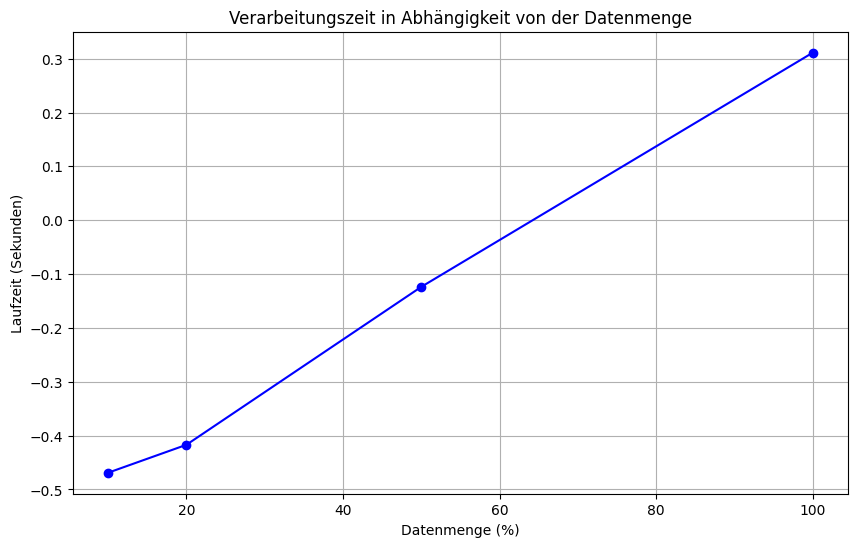

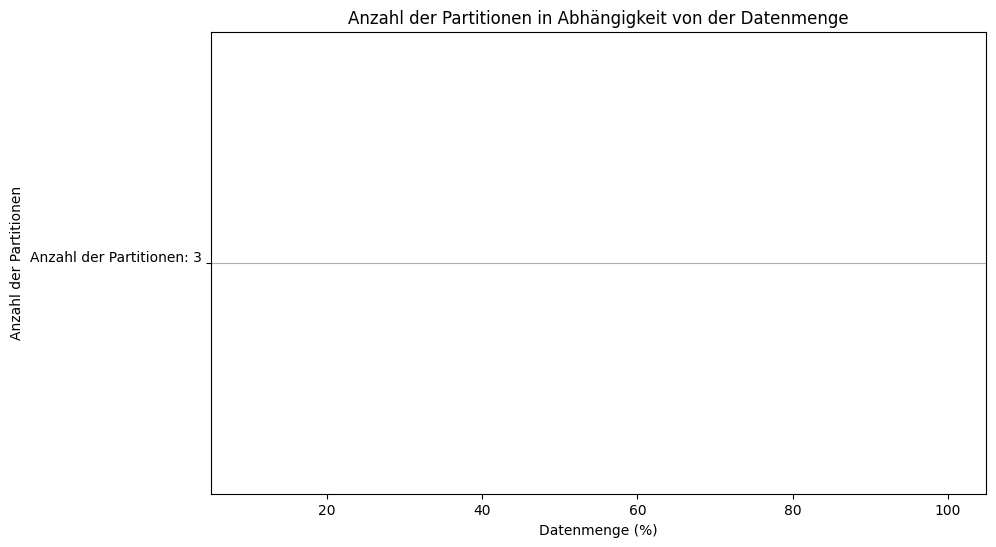

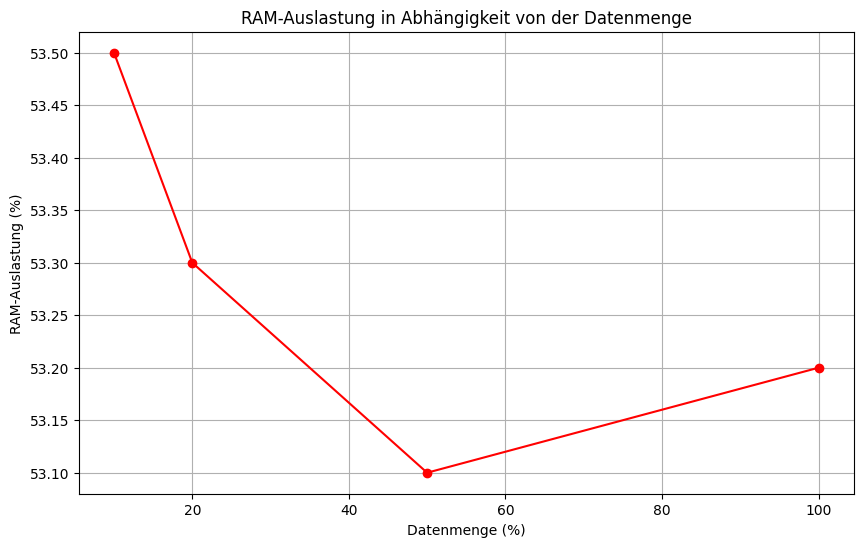

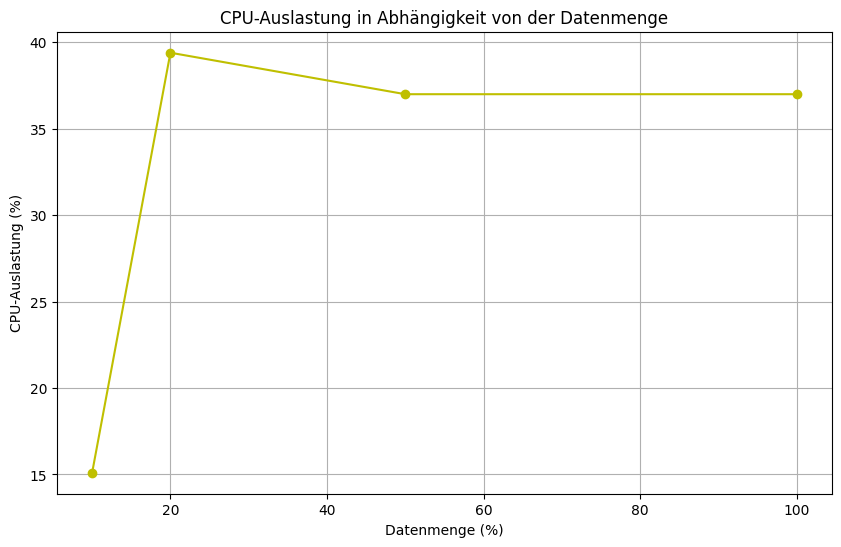

In [ ]:
import time
import matplotlib.pyplot as plt


# Skalierbarkeit

# Definition der zu verarbeitenden Datenmenge
percentages = [0.1, 0.2, 0.5, 1.0]  # 10%, 20%, 50%, 100%

# Listen für Plot vorbereiten
x_data = []
y_time = []
number_partition_data = []
memory_data = []
cpu_data = []

for percentage in percentages:
    print(f"\nVerarbeite {percentage*100}% der Daten...")

    # Startzeit messen
    start_time = time.time()

    # Funktion aufrufen
    result_text, map_result, dataRDD = analyze_flight_movements(flight_data_path, percentage=percentage)
    
    # Messwerte erheben
    virtual_memory = psutil.virtual_memory()  # Virtueller Speicher (RAM)
    memory_percent = virtual_memory.percent  # Prozentsatz des verwendeten RAM
    cpu_percent = psutil.cpu_percent(interval=None) # Messung direkt nach Ausführung der FUnktion

    # Endzeit messen
    end_time = time.time()
        
    # Daten für den Plot sammeln
    number_data, number_partition, result = analyze_partition_distribution(dataRDD)
    x_data.append(percentage * 100)  # Prozentuale Datenmenge
    y_time.append(end_time-start_time-base_time)  # Verarbeitungszeit abzüglich Basiszeit
    number_partition_data.append(number_partition)
    memory_data.append(memory_percent)
    cpu_data.append(cpu_percent)

# Plot 1: Laufzeit
plt.figure(figsize=(10, 6))
plt.plot(x_data, y_time, marker='o', linestyle='-', color='b')
plt.title('Verarbeitungszeit in Abhängigkeit von der Datenmenge')
plt.xlabel('Datenmenge (%)')
plt.ylabel('Laufzeit (Sekunden)')
plt.grid(True)
plt.show()

# Plot 2: Anzahl der Partitionen
plt.figure(figsize=(10, 6))
plt.bar(x_data, number_partition_data, color='g', alpha=0.7)
plt.title('Anzahl der Partitionen in Abhängigkeit von der Datenmenge')
plt.xlabel('Datenmenge (%)')
plt.ylabel('Anzahl der Partitionen')
plt.grid(axis='y')
plt.show()

# Plot 3: RAM-Auslastung
plt.figure(figsize=(10, 6))
plt.plot(x_data, memory_data, marker='o', linestyle='-', color='r')
plt.title('RAM-Auslastung in Abhängigkeit von der Datenmenge')
plt.xlabel('Datenmenge (%)')
plt.ylabel('RAM-Auslastung (%)')
plt.grid(True)
plt.show()

# Plot 4: CPU-Auslastung
plt.figure(figsize=(10, 6))
plt.plot(x_data, cpu_data, marker='o', linestyle='-', color='y')
plt.title('CPU-Auslastung in Abhängigkeit von der Datenmenge')
plt.xlabel('Datenmenge (%)')
plt.ylabel('CPU-Auslastung (%)')
plt.grid(True)
plt.show()

In [29]:
# Fehlertoleranz


**Analyse 4 - Kombinierte Flugobekte und Bewegungsdaten**

- Basiszeitmessung:
  - Führt die Funktionen `analyze_flight_movements`, `restructure_flight_movements`, `analyze_aircraft_data`, `combine_rdds` und `analyze_combined_rdd` mit einem sehr kleinen Datenanteil (`0.0001%`) aus.
  - Misst die dafür benötigte Zeit, um eine Basiszeit (`base_time`) zu bestimmen.
  
- Laufzeitmessung:
  - Führt dieselben Funktionen mit `100%` der Daten aus.
  - Misst die gesamte Ausführungszeit und subtrahiert die zuvor ermittelte Basiszeit, um die tatsächliche Verarbeitungszeit zu berechnen.
  
- Datenverteilung:
  - Analysiert die Verteilung der Daten im kombinierten RDD über die verschiedenen Partitionen mithilfe der Funktion `analyze_partition_distribution`.
  
- Ausgabe:
  - Gibt die berechnete Laufzeit für die Verarbeitung der vollständigen Datenmenge sowie die Ergebnisse der Datenverteilungsanalyse aus.


In [ ]:
import time
import matplotlib.pyplot as plt

# Basiszeit

# Startzeit messen
start_time = time.time() 

# Funktionen aufrufen
result_text, map_result, dataRDD = analyze_flight_movements(flight_data_path, percentage=0.0001)
vehicle_rdd_rdd = restructure_flight_movements(dataRDD)
result, aircraft_raw_rdd, aircraftRDD = analyze_aircraft_data(aircraft_data_path)
combined_rdd = combine_rdds(vehicle_rdd, aircraft_raw_rdd)
combined_analyzed_rdd, result = analyze_combined_rdd(combined_rdd, 0.0001) #0.01% der Daten für Basiszeit

# Endzeit messen
end_time = time.time()

#Basiszeit errechnen
base_time = end_time-start_time


# Laufzeit

# Startzeit messen
start_time = time.time()

# Funktionen aufrufen
result_text, map_result, dataRDD = analyze_flight_movements(flight_data_path)
vehicle_rdd = restructure_flight_movements(dataRDD)    
result, aircraft_raw_rdd, aircraftRDD = analyze_aircraft_data(aircraft_data_path)
combined_rdd = combine_rdds(vehicle_rdd, aircraft_raw_rdd)
combined_analyzed_rdd, result = analyze_combined_rdd(combined_rdd)

# Endzeit messen
end_time = time.time()

print(f"Die Funktion hat für 100% der Daten {end_time - start_time:.4f} Sekunden benötigt")
print(result)
print()


# Datenverteilung
number_data, number_partition, result = analyze_partition_distribution(combined_analyzed_rdd)
print(number_data + number_partition + result)


0.06642300000000034


Die Funktion hat für 100% der Daten 0.0679 Sekunden benötigt
Anzahl der im betrachteten Zeitraum aktiven Flug- und Bodenobjekte: 464
Flugzeuge mit den meisten Datensätzen (Top 5) sind: [('4bc841', 3599), ('a08663', 3599), ('a3b268', 3599), ('4bb20b', 3599), ('a9b9e3', 3599)]
Status der Objekt zum letzten gemessenen Zeitpunkt: 
Objekte aktuell in der Luft: 382
Objekte aktuell am Boden: 82
Im gesamten betrachteten Zeitraum sind: 
Objekte nur am Boden geblieben: 37
Objekte nur in der Luft geblieben: 308
Objekte gestartet oder gelandet: 119

Anzahl der Datensätze: 464
Anzahl der Partitionen: 7
Datenverteilung auf Partitionen:
Partition 0: 65 Datensätze
Partition 1: 77 Datensätze
Partition 2: 54 Datensätze
Partition 3: 63 Datensätze
Partition 4: 66 Datensätze
Partition 5: 76 Datensätze
Partition 6: 63 Datensätze



**Messungen**

- Skalierbarkeitstest:
  - Definiert verschiedene Datenmengen (10%, 20%, 50%, 100%) zur Analyse der Verarbeitungseffizienz.
  
- Leistungsmetriken erfassen:
  - Laufzeitmessung: Misst die Ausführungszeit der Funktion `analyze_flight_movements` für jede Datenmenge und subtrahiert die Basiszeit.
  - Datenverteilung: Analysiert, wie die Daten über die Spark-Partitionen verteilt sind.
  - Speicherauslastung: Erfasst die RAM-Auslastung nach der Verarbeitung.
  - CPU-Auslastung: Misst die CPU-Auslastung unmittelbar nach der Verarbeitung.
  
- Datenvisualisierung:
  - Erstellt vier Diagramme mit Matplotlib, um die gesammelten Leistungsmetriken in Abhängigkeit von der verarbeiteten Datenmenge darzustellen:
    1. Verarbeitungszeit vs. **Datenmenge (%)
    2. Anzahl der Partitionen vs. Datenmenge (%)
    3. RAM-Auslastung vs. Datenmenge (%)
    4. CPU-Auslastung vs. Datenmenge (%)


Verarbeite 10.0% der Daten...



Verarbeite 20.0% der Daten...



Verarbeite 50.0% der Daten...



Verarbeite 100.0% der Daten...


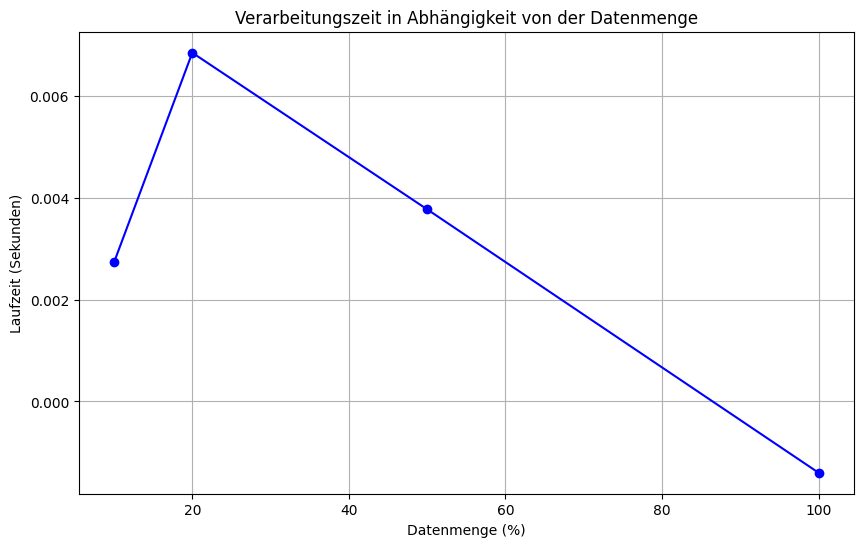

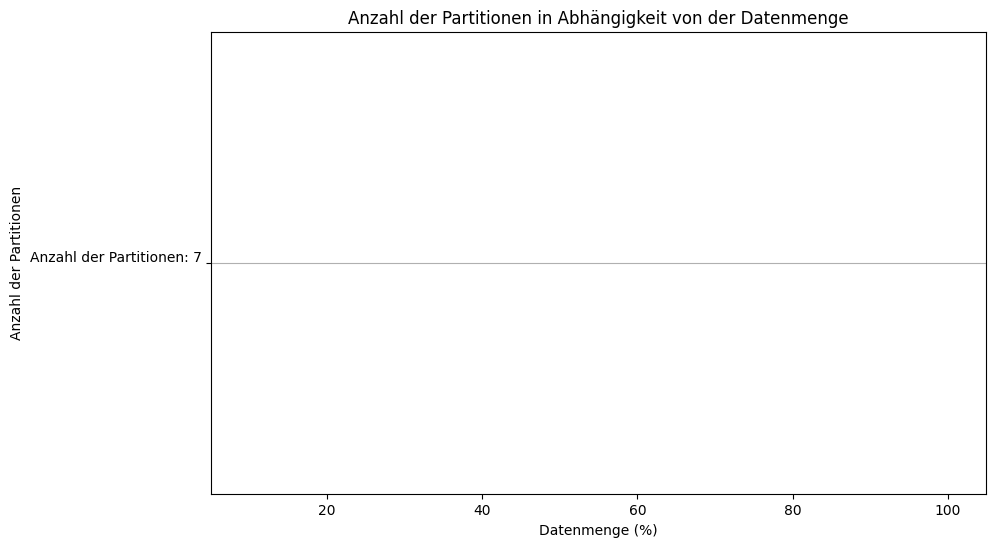

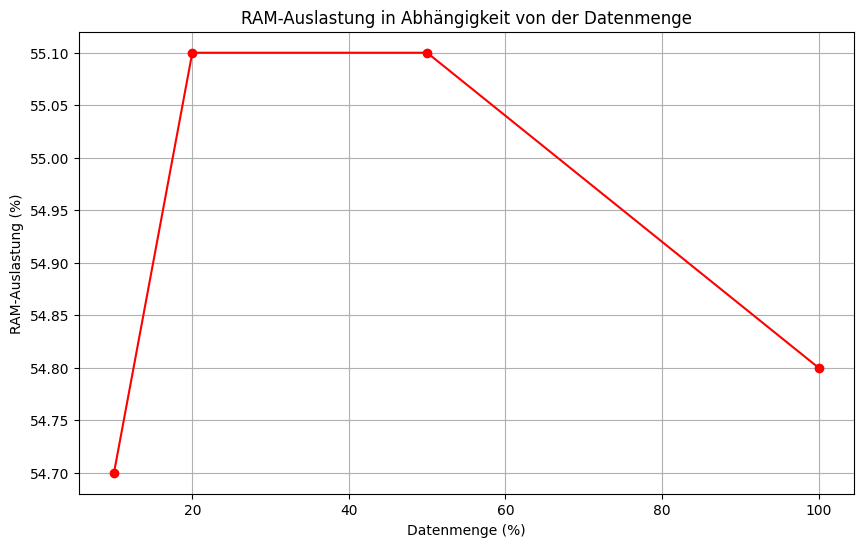

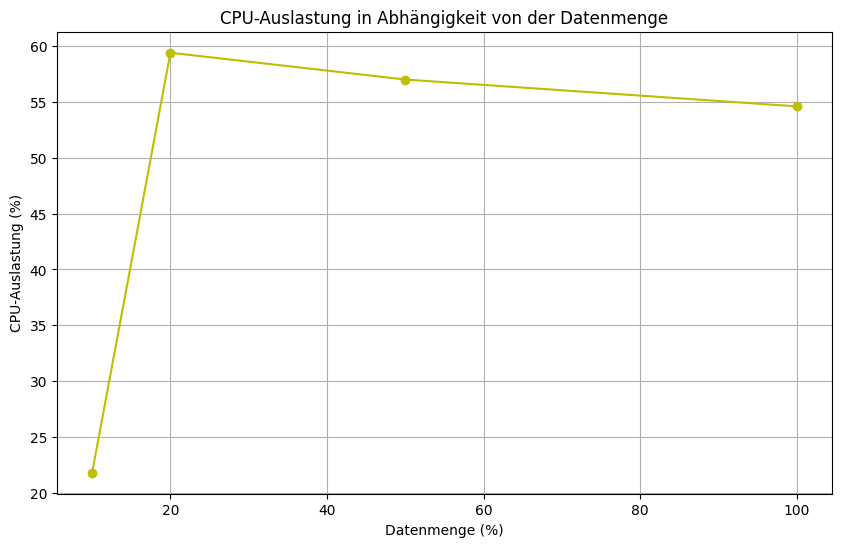

In [ ]:
import time
import matplotlib.pyplot as plt


# Skalierbarkeit

# Definition der zu verarbeitenden Datenmenge
percentages = [0.1, 0.2, 0.5, 1.0]  # 10%, 20%, 50%, 100%

# Listen für Plot vorbereiten
x_data = []
y_time = []
number_partition_data = []
memory_data = []
cpu_data = []

for percentage in percentages:
    print(f"\nVerarbeite {percentage*100}% der Daten...")
    
    # Startzeit messen
    start_time = time.time()

    # Funktionen aufrufen
    result_text, map_result, dataRDD = analyze_flight_movements(flight_data_path, percentage=percentage)
    vehicle_rdd_rdd = restructure_flight_movements(dataRDD)
    result, aircraft_raw_rdd, aircraftRDD = analyze_aircraft_data(aircraft_data_path)
    combined_rdd = combine_rdds(vehicle_rdd, aircraft_raw_rdd)
    combined_analyzed_rdd, result = analyze_combined_rdd(combined_rdd, percentage)
    
    # Messwerte erheben
    virtual_memory = psutil.virtual_memory()  # Virtueller Speicher (RAM)
    memory_percent = virtual_memory.percent  # Prozentsatz des verwendeten RAM
    cpu_percent = psutil.cpu_percent(interval=None) # Messung direkt nach Ausführung der FUnktion
    
    # Endzeit messen
    end_time = time.time()
    

    # Daten für den Plot sammeln
    number_data, number_partition, result = analyze_partition_distribution(combined_analyzed_rdd)
    x_data.append(percentage * 100)  # Prozentuale Datenmenge
    y_time.append(end_time-start_time-base_time)  # Verarbeitungszeit abzüglich Basiszeit
    number_partition_data.append(number_partition)
    memory_data.append(memory_percent)
    cpu_data.append(cpu_percent)
  

# Plot 1: Laufzeit
plt.figure(figsize=(10, 6))
plt.plot(x_data, y_time, marker='o', linestyle='-', color='b')
plt.title('Verarbeitungszeit in Abhängigkeit von der Datenmenge')
plt.xlabel('Datenmenge (%)')
plt.ylabel('Laufzeit (Sekunden)')
plt.grid(True)
plt.show()

# Plot 2: Anzahl der Partitionen
plt.figure(figsize=(10, 6))
plt.bar(x_data, number_partition_data, color='g', alpha=0.7)
plt.title('Anzahl der Partitionen in Abhängigkeit von der Datenmenge')
plt.xlabel('Datenmenge (%)')
plt.ylabel('Anzahl der Partitionen')
plt.grid(axis='y')
plt.show()

# Plot 3: RAM-Auslastung
plt.figure(figsize=(10, 6))
plt.plot(x_data, memory_data, marker='o', linestyle='-', color='r')
plt.title('RAM-Auslastung in Abhängigkeit von der Datenmenge')
plt.xlabel('Datenmenge (%)')
plt.ylabel('RAM-Auslastung (%)')
plt.grid(True)
plt.show()

# Plot 4: CPU-Auslastung
plt.figure(figsize=(10, 6))
plt.plot(x_data, cpu_data, marker='o', linestyle='-', color='y')
plt.title('CPU-Auslastung in Abhängigkeit von der Datenmenge')
plt.xlabel('Datenmenge (%)')
plt.ylabel('CPU-Auslastung (%)')
plt.grid(True)
plt.show()



In [ ]:
# Fehlertoleranz

Analyse 5 - Heatmap

- Basiszeitmessung:
  - Führt die Funktionen `analyze_flight_movements`, `process_and_reduce` und `create_heatmap` mit einem sehr kleinen Datenanteil (`0.0001%`) aus.
  - Misst die dafür benötigte Zeit (`base_time`), um eine Basiszeit zu bestimmen.
  
- Laufzeitmessung:
  - Führt dieselben Funktionen mit `100%` der Daten aus.
  - Misst die gesamte Ausführungszeit und subtrahiert die zuvor ermittelte Basiszeit, um die tatsächliche Verarbeitungszeit zu berechnen.
  
- Datenverteilung: Analysiert die Verteilung der Daten im reduzierten RDD über die verschiedenen Partitionen mithilfe der Funktion `analyze_partition_distribution`.
  
- Ausgabe:
  - Gibt die berechnete Laufzeit für die Verarbeitung der vollständigen Datenmenge sowie die Ergebnisse der Datenverteilungsanalyse aus.
  - Erstellt und zeigt eine Heatmap basierend auf den reduzierten Koordinaten.

In [24]:
import time
import matplotlib.pyplot as plt

# Basiszeit

# Startzeit messen
start_time = time.time()

# Funktionen aufrufen
result_text, map_result, dataRDD = analyze_flight_movements(flight_data_path, percentage=0.0001)
reduced_rdd, result = process_and_reduce(dataRDD)
map = create_heatmap(reduced_rdd)

# Endzeit messen
end_time = time.time()

# Basiszeit errechenen
base_time = end_time-start_time


# Laufzeit

# Startzeit messen
start_time = time.time()

# Funktionen aufrufen
result_text, map_result, dataRDD = analyze_flight_movements(flight_data_path)
reduced_rdd, result = process_and_reduce(dataRDD)
print(result)
map = create_heatmap(reduced_rdd)

# Endzeit messen
end_time = time.time()

print(f"Die Funktion hat für 100% der Daten {(end_time - start_time - base_time):.4f} Sekunden benötigt")
print(result)
print()


# Datenverteilung
number_data, number_partition, result = analyze_partition_distribution(reduced_rdd)
print(number_data + number_partition + result)


Anzahl der Daten vor der Reduktion: 958473
Anzahl Koordinaten nach der Reduktion: 18748

Die Funktion hat für 100% der Daten 1.5018 Sekunden benötigt
Anzahl der Daten vor der Reduktion: 958473
Anzahl Koordinaten nach der Reduktion: 18748


Anzahl der Datensätze: 18748
Anzahl der Partitionen: 3
Datenverteilung auf Partitionen:
Partition 0: 6237 Datensätze
Partition 1: 6163 Datensätze
Partition 2: 6348 Datensätze



**Messungen**

- Basiszeitmessung:
  - Führt die Funktionen `analyze_flight_movements`, `restructure_flight_movements`, `analyze_aircraft_data`, `combine_rdds` und `analyze_combined_rdd` mit einem sehr kleinen Datenanteil (`0.0001%`) aus.
  - Misst die dafür benötigte Zeit (`base_time`), um eine Basiszeit zu bestimmen.

- Laufzeitmessung:
  - Führt dieselben Funktionen mit `100%` der Daten aus.
  - Misst die gesamte Ausführungszeit und subtrahiert die zuvor ermittelte Basiszeit, um die tatsächliche Verarbeitungszeit zu berechnen.
  - Gibt die berechnete Laufzeit sowie die Ergebnisse der Datenverteilungsanalyse aus.

- Skalierbarkeitstest:
  - Definiert verschiedene Datenmengen (`10%`, `20%`, `50%`, `100%`) zur Analyse der Verarbeitungseffizienz.
  - Für jede Datenmenge:
    - Führt die Funktionen `analyze_flight_movements`, `process_and_reduce` und `create_heatmap` aus.
    - Erfasst Leistungsmetriken wie RAM-Auslastung und CPU-Auslastung.
    - Analysiert die Datenverteilung über die Spark-Partitionen.
    - Speichert die gesammelten Daten für die spätere Visualisierung.

- Datenvisualisierung:
  - Erstellt vier Diagramme mit Matplotlib, um die gesammelten Leistungsmetriken in Abhängigkeit von der verarbeiteten Datenmenge darzustellen:
    1. Verarbeitungszeit vs. Datenmenge (%)
    2. Anzahl der Partitionen vs. Datenmenge (%)
    3. RAM-Auslastung vs. Datenmenge (%)
    4. CPU-Auslastung vs. Datenmenge (%)


Verarbeite 10.0% der Daten...

Verarbeite 20.0% der Daten...

Verarbeite 50.0% der Daten...

Verarbeite 100.0% der Daten...


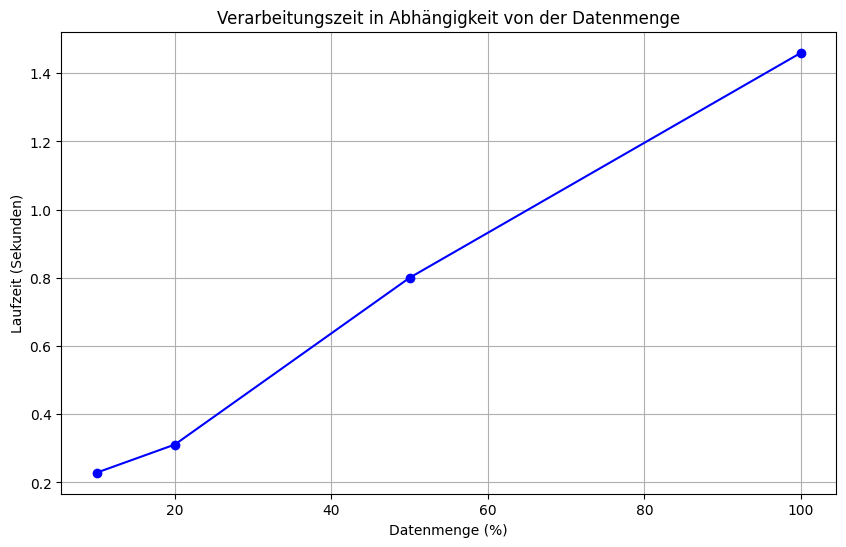

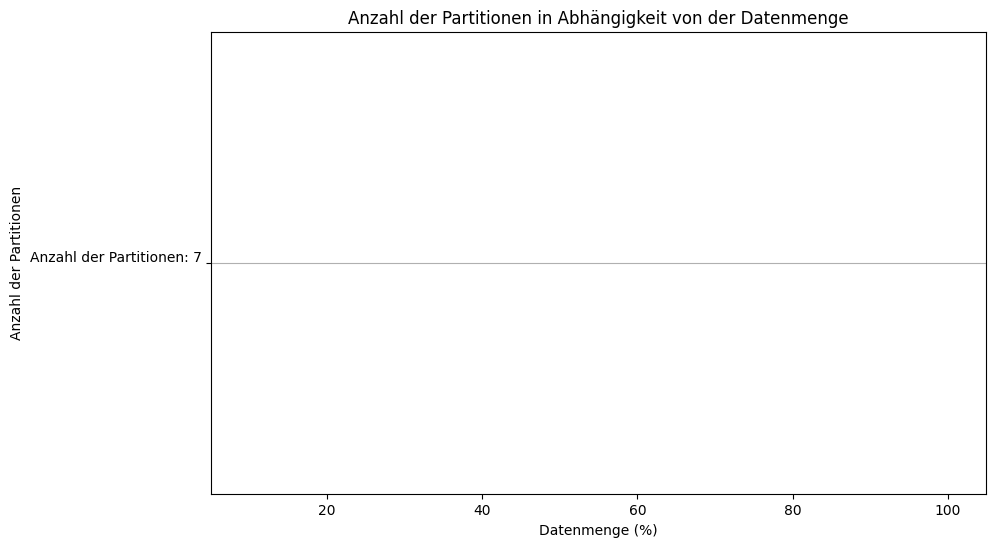

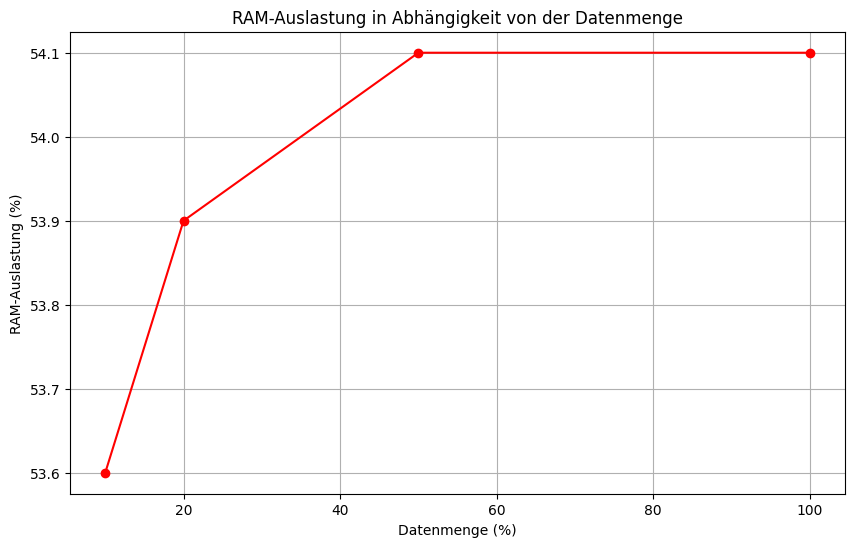

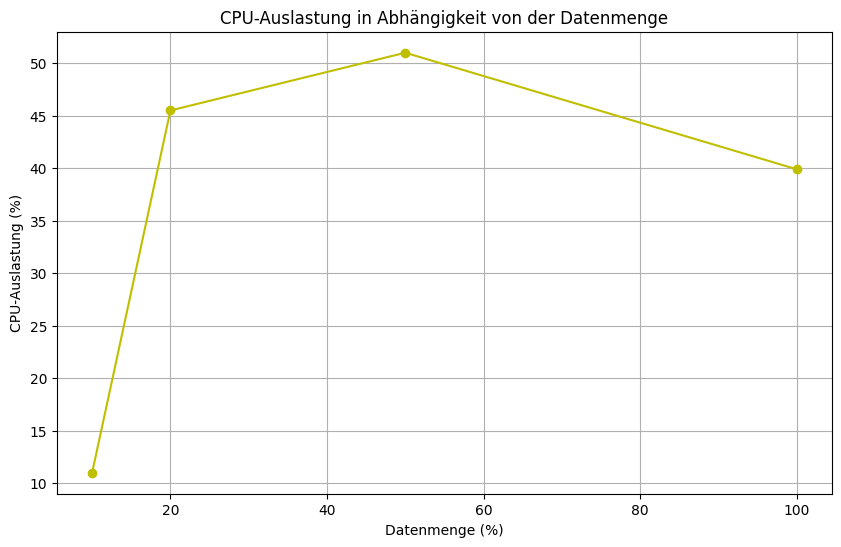

In [ ]:
import time
import matplotlib.pyplot as plt

# Skalierbarkeit

# Definition der zu verarbeitenden Datenmenge
percentages = [0.1, 0.2, 0.5, 1.0]  # 10%, 20%, 50%, 100%

# Listen für Plot vorbereiten
x_data = []
y_time = []
number_partition_data = []
memory_data = []
cpu_data = []

for percentage in percentages:
    print(f"\nVerarbeite {percentage*100}% der Daten...")
    
    # Startzeit messen
    start_time = time.time()

    # Funktionen aufrufen
    result_text, map_result, dataRDD = analyze_flight_movements(flight_data_path, percentage=percentage)
    reduced_rdd, result = process_and_reduce(dataRDD)
    map = create_heatmap(reduced_rdd)
   
    # Messwerte erheben
    virtual_memory = psutil.virtual_memory()  # Virtueller Speicher (RAM)
    memory_percent = virtual_memory.percent  # Prozentsatz des verwendeten RAM
    cpu_percent = psutil.cpu_percent(interval=None) # Messung direkt nach Ausführung der FUnktion
    
    # Endzeit messen
    end_time = time.time()
    
    # Daten für den Plot sammeln
    number_data, number_partition, result = analyze_partition_distribution(combined_analyzed_rdd)
    x_data.append(percentage * 100)  # Prozentuale Datenmenge
    y_time.append(end_time-start_time-base_time)  # Verarbeitungszeit abzüglich Basiszeit
    number_partition_data.append(number_partition)
    memory_data.append(memory_percent)
    cpu_data.append(cpu_percent)

# Plot 1: Laufzeit
plt.figure(figsize=(10, 6))
plt.plot(x_data, y_time, marker='o', linestyle='-', color='b')
plt.title('Verarbeitungszeit in Abhängigkeit von der Datenmenge')
plt.xlabel('Datenmenge (%)')
plt.ylabel('Laufzeit (Sekunden)')
plt.grid(True)
plt.show()

# Plot 2: Anzahl der Partitionen
plt.figure(figsize=(10, 6))
plt.bar(x_data, number_partition_data, color='g', alpha=0.7)
plt.title('Anzahl der Partitionen in Abhängigkeit von der Datenmenge')
plt.xlabel('Datenmenge (%)')
plt.ylabel('Anzahl der Partitionen')
plt.grid(axis='y')
plt.show()

# Plot 3: RAM-Auslastung
plt.figure(figsize=(10, 6))
plt.plot(x_data, memory_data, marker='o', linestyle='-', color='r')
plt.title('RAM-Auslastung in Abhängigkeit von der Datenmenge')
plt.xlabel('Datenmenge (%)')
plt.ylabel('RAM-Auslastung (%)')
plt.grid(True)
plt.show()

# Plot 4: CPU-Auslastung
plt.figure(figsize=(10, 6))
plt.plot(x_data, cpu_data, marker='o', linestyle='-', color='y')
plt.title('CPU-Auslastung in Abhängigkeit von der Datenmenge')
plt.xlabel('Datenmenge (%)')
plt.ylabel('CPU-Auslastung (%)')
plt.grid(True)
plt.show()


In [ ]:
#Fehlertoleranz
